In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
import sys
import pickle as pkl
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch
import math
import math
import matplotlib.pyplot as plt


import torch

from torch.nn.parameter import Parameter

from torch.nn.modules.module import Module

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# utils

In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
import sys
import pickle as pkl
import numpy as np
import networkx as nx

def common_loss(emb1, emb2):
    emb1 = emb1 - torch.mean(emb1, dim=0, keepdim=True)
    emb2 = emb2 - torch.mean(emb2, dim=0, keepdim=True)
    emb1 = torch.nn.functional.normalize(emb1, p=2, dim=1)
    emb2 = torch.nn.functional.normalize(emb2, p=2, dim=1)
    cov1 = torch.matmul(emb1, emb1.t())
    cov2 = torch.matmul(emb2, emb2.t())
    cost = torch.mean((cov1 - cov2)**2)
    return cost


def loss_dependence(emb1, emb2, dim):
    R = torch.eye(dim).cuda() - (1/dim) * torch.ones(dim, dim).cuda()
    K1 = torch.mm(emb1, emb1.t())
    K2 = torch.mm(emb2, emb2.t())
    RK1 = torch.mm(R, K1)
    RK2 = torch.mm(R, K2)
    HSIC = torch.trace(torch.mm(RK1, RK2))
    return HSIC



def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx



In [ ]:
def load_data():
    f = np.loadtxt(feature_path, dtype = float)
    l = np.loadtxt(label_path, dtype = int)
    test = np.loadtxt(test_path, dtype = int)
    train = np.loadtxt(train_path, dtype = int)
    features = sp.csr_matrix(f, dtype=np.float32)
    features = torch.FloatTensor(np.array(features.todense()))

    idx_test = test.tolist()
    idx_train = train.tolist()

    idx_train = torch.LongTensor(idx_train)
    idx_test = torch.LongTensor(idx_test)

    label = torch.LongTensor(np.array(l))

    return features, label, idx_train, idx_test


def load_graph(dataset):
    # load feature graph
    featuregraph_path1 = featuregraph_path + str(k) + '.txt'

    feature_edges = np.genfromtxt(featuregraph_path1, dtype=np.int32)
    fedges = np.array(list(feature_edges), dtype=np.int32).reshape(feature_edges.shape)
    fadj = sp.coo_matrix((np.ones(fedges.shape[0]), (fedges[:, 0], fedges[:, 1])), shape=(n, n), dtype=np.float32)
    fadj = fadj + fadj.T.multiply(fadj.T > fadj) - fadj.multiply(fadj.T > fadj)
    nfadj = normalize(fadj + sp.eye(fadj.shape[0]))

    struct_edges = np.genfromtxt(structgraph_path, dtype=np.int32)
    sedges = np.array(list(struct_edges), dtype=np.int32).reshape(struct_edges.shape)
    sadj = sp.coo_matrix((np.ones(sedges.shape[0]), (sedges[:, 0], sedges[:, 1])), shape=(n, n), dtype=np.float32)
    sadj = sadj + sadj.T.multiply(sadj.T > sadj) - sadj.multiply(sadj.T > sadj)
    nsadj = normalize(sadj+sp.eye(sadj.shape[0]))

    nsadj = sparse_mx_to_torch_sparse_tensor(nsadj)
    nfadj = sparse_mx_to_torch_sparse_tensor(nfadj)

    return nsadj, nfadj

In [ ]:
def load_graph_gcn(dataset):
    struct_edges = np.genfromtxt(structgraph_path, dtype=np.int32)
    sedges = np.array(list(struct_edges), dtype=np.int32).reshape(struct_edges.shape)
    sadj = sp.coo_matrix((np.ones(sedges.shape[0]), (sedges[:, 0], sedges[:, 1])), shape=(n, n), dtype=np.float32)
    sadj = sadj + sadj.T.multiply(sadj.T > sadj) - sadj.multiply(sadj.T > sadj)
    nsadj = normalize(sadj+sp.eye(sadj.shape[0]))

    nsadj = sparse_mx_to_torch_sparse_tensor(nsadj)

    return nsadj


# layers

In [ ]:

class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [ ]:



class GCN(nn.Module):
    def __init__(self, nfeat, nhid, out, dropout):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, out)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training = self.training)
        x = self.gc2(x, adj)
        return x


class Attention(nn.Module):
    def __init__(self, in_size, hidden_size=16):
        super(Attention, self).__init__()

        self.project = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1, bias=False)
        )

    def forward(self, z):
        w = self.project(z)
        beta = torch.softmax(w, dim=1)
        return (beta * z).sum(1), beta

class SFGCN(nn.Module):
    def __init__(self, nfeat, nclass, nhid1, nhid2, n, dropout):
        super(SFGCN, self).__init__()

        self.SGCN1 = GCN(nfeat, nhid1, nhid2, dropout)
        self.SGCN2 = GCN(nfeat, nhid1, nhid2, dropout)
        self.CGCN = GCN(nfeat, nhid1, nhid2, dropout)

        self.dropout = dropout
        self.a = nn.Parameter(torch.zeros(size=(nhid2, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.attention = Attention(nhid2)
        self.tanh = nn.Tanh()

        self.MLP = nn.Sequential(
            nn.Linear(nhid2, nclass),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x, sadj, fadj):
        emb1 = self.SGCN1(x, sadj) # Special_GCN out1 -- sadj structure graph
        com1 = self.CGCN(x, sadj)  # Common_GCN out1 -- sadj structure graph
        com2 = self.CGCN(x, fadj)  # Common_GCN out2 -- fadj feature graph
        emb2 = self.SGCN2(x, fadj) # Special_GCN out2 -- fadj feature graph
        Xcom = (com1 + com2) / 2
        ##attention
        emb = torch.stack([emb1, emb2, Xcom], dim=1)
        emb, att = self.attention(emb)
        # print(att)
        output = self.MLP(emb)
        return output, att, emb1, com1, com2, emb2, emb



class SGCN(nn.Module):
    def __init__(self, nfeat, nclass, nhid1, nhid2, n, dropout):
        super(SGCN, self).__init__()

        self.SGCN1 = GCN(nfeat, nhid1, nhid2, dropout)
        # self.SGCN2 = GCN(nfeat, nhid1, nhid2, dropout)
        self.CGCN = GCN(nfeat, nhid1, nhid2, dropout)

        self.dropout = dropout
        self.a = nn.Parameter(torch.zeros(size=(nhid2, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.attention = Attention(nhid2)
        self.tanh = nn.Tanh()

        self.MLP = nn.Sequential(
            nn.Linear(nhid2, nclass),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x, sadj, fadj):
        emb1 = self.SGCN1(x, sadj) # Special_GCN out1 -- sadj structure graph
        com1 = self.CGCN(x, sadj)  # Common_GCN out1 -- sadj structure graph
        com2 = self.CGCN(x, fadj)  # Common_GCN out2 -- fadj feature graph
        # emb2 = self.SGCN2(x, fadj) # Special_GCN out2 -- fadj feature graph
        Xcom = (com1 + com2) / 2
        ##attention
        emb = torch.stack([emb1, Xcom], dim=1)
        emb, att = self.attention(emb)
        output = self.MLP(emb)
        return output, att, emb1, com1, com2, emb


class FGCN(nn.Module):
    def __init__(self, nfeat, nclass, nhid1, nhid2, n, dropout):
        super(FGCN, self).__init__()

        # self.SGCN1 = GCN(nfeat, nhid1, nhid2, dropout)
        self.SGCN2 = GCN(nfeat, nhid1, nhid2, dropout)
        self.CGCN = GCN(nfeat, nhid1, nhid2, dropout)

        self.dropout = dropout
        self.a = nn.Parameter(torch.zeros(size=(nhid2, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.attention = Attention(nhid2)
        self.tanh = nn.Tanh()

        self.MLP = nn.Sequential(
            nn.Linear(nhid2, nclass),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x, sadj, fadj):
        # emb1 = self.SGCN1(x, sadj) # Special_GCN out1 -- sadj structure graph
        com1 = self.CGCN(x, sadj)  # Common_GCN out1 -- sadj structure graph
        com2 = self.CGCN(x, fadj)  # Common_GCN out2 -- fadj feature graph
        emb2 = self.SGCN2(x, fadj) # Special_GCN out2 -- fadj feature graph
        Xcom = (com1 + com2) / 2
        ##attention
        emb = torch.stack([emb2, Xcom], dim=1)
        emb, att = self.attention(emb)
        print(att)
        output = self.MLP(emb)
        return output, att, emb2, com1, com2, emb

class sfGCN(nn.Module):
    def __init__(self, nfeat, nclass, nhid1, nhid2, n, dropout):
        super(sfGCN, self).__init__()

        self.SGCN1 = GCN(nfeat, nhid1, nhid2, dropout)
        self.SGCN2 = GCN(nfeat, nhid1, nhid2, dropout)
        # self.CGCN = GCN(nfeat, nhid1, nhid2, dropout)

        self.dropout = dropout
        self.a = nn.Parameter(torch.zeros(size=(nhid2, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.attention = Attention(nhid2)
        self.tanh = nn.Tanh()

        self.MLP = nn.Sequential(
            nn.Linear(nhid2, nclass),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x, sadj, fadj):
        emb1 = self.SGCN1(x, sadj) # Special_GCN out1 -- sadj structure graph
        # com1 = self.CGCN(x, sadj)  # Common_GCN out1 -- sadj structure graph
        # com2 = self.CGCN(x, fadj)  # Common_GCN out2 -- fadj feature graph
        emb2 = self.SGCN2(x, fadj) # Special_GCN out2 -- fadj feature graph
        # Xcom = (com1 + com2) / 2
        ##attention
        emb = torch.stack([emb1, emb2], dim=1)
        emb, att = self.attention(emb)
        # print(att)
        output = self.MLP(emb)
        return output, att, emb1, emb2, emb

In [ ]:
# class ComGCN(nn.Module):
#     def __init__(self, nfeat, nclass, nhid1, nhid2, n, dropout):
#         super(FGCN, self).__init__()

#         # self.SGCN1 = GCN(nfeat, nhid1, nhid2, dropout)
#         # self.SGCN2 = GCN(nfeat, nhid1, nhid2, dropout)
#         self.CGCN = GCN(nfeat, nhid1, nhid2, dropout)

#         self.dropout = dropout
#         self.a = nn.Parameter(torch.zeros(size=(nhid2, 1)))
#         nn.init.xavier_uniform_(self.a.data, gain=1.414)
#         self.attention = Attention(nhid2)
#         self.tanh = nn.Tanh()

#         self.MLP = nn.Sequential(
#             nn.Linear(nhid2, nclass),
#             nn.LogSoftmax(dim=1)
#         )

#     def forward(self, x, sadj, fadj):
#         # emb1 = self.SGCN1(x, sadj) # Special_GCN out1 -- sadj structure graph
#         com1 = self.CGCN(x, sadj)  # Common_GCN out1 -- sadj structure graph
#         com2 = self.CGCN(x, fadj)  # Common_GCN out2 -- fadj feature graph
#         # emb2 = self.SGCN2(x, fadj) # Special_GCN out2 -- fadj feature graph
#         Xcom = (com1 + com2) / 2
#         ##attention
#         emb = torch.stack([emb2, Xcom], dim=1)
#         emb, att = self.attention(emb)
#         output = self.MLP(emb)
#         return output, att, emb2, com1, com2, emb

# main

In [ ]:
from __future__ import division
from __future__ import print_function
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import numpy
from sklearn.metrics import f1_score
import os
import torch.nn as nn
#AMGCN
###################


In [ ]:
# python main.py -d dataset -l labelrate
# python main.py -d citeseer -l 20

In [ ]:
def train(model, epochs):
    model.train()
    optimizer.zero_grad()
    output, att, emb1, com1, com2, emb2, emb= model(features, sadj, fadj)
    loss_class =  F.nll_loss(output[idx_train], labels[idx_train])
    loss_dep = (loss_dependence(emb1, com1, n) + loss_dependence(emb2, com2, n))/2
    loss_com = common_loss(com1,com2)
    loss = loss_class + beta * loss_dep + theta * loss_com
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    acc_test, macro_f1, emb_test = main_test(model)
    print('e:{}'.format(epochs),
            'ltr: {:.4f}'.format(loss.item()),
            'atr: {:.4f}'.format(acc.item()),
            'ate: {:.4f}'.format(acc_test.item()),
            'f1te:{:.4f}'.format(macro_f1.item()))
    return loss.item(), acc_test.item(), macro_f1.item(), emb_test

def main_test(model):
    model.eval()
    output, att, emb1, com1, com2, emb2, emb = model(features, sadj, fadj)
    acc_test = accuracy(output[idx_test], labels[idx_test])
    label_max = []
    for idx in idx_test:
        label_max.append(torch.argmax(output[idx]).item())
    labelcpu = labels[idx_test].data.cpu()
    macro_f1 = f1_score(labelcpu, label_max, average='macro')
    return acc_test, macro_f1, emb

def train_att(model, epochs):
    model.train()
    optimizer.zero_grad()
    output, att, emb1, com1, com2, emb2, emb= model(features, sadj, fadj)
    loss_class =  F.nll_loss(output[idx_train], labels[idx_train])
    loss_dep = (loss_dependence(emb1, com1, n) + loss_dependence(emb2, com2, n))/2
    loss_com = common_loss(com1,com2)
    loss = loss_class + beta * loss_dep + theta * loss_com
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    acc_test, macro_f1, emb_test = main_test(model)
    print('e:{}'.format(epochs),
            'ltr: {:.4f}'.format(loss.item()),
            'atr: {:.4f}'.format(acc.item()),
            'ate: {:.4f}'.format(acc_test.item()),
            'f1te:{:.4f}'.format(macro_f1.item()))
    return loss.item(), acc_test.item(), macro_f1.item(), emb_test, att

In [ ]:
def train_s_att(model, epochs):
    model.train()
    optimizer.zero_grad()
    output, att, emb1, com1, com2, emb= model(features, sadj, fadj)
    loss_class =  F.nll_loss(output[idx_train], labels[idx_train])
    loss_dep = loss_dependence(emb1, com1, n)
    loss_com = common_loss(com1,com2)
    loss = loss_class + beta * loss_dep + theta * loss_com
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    acc_test, macro_f1, emb_test = main_test_s(model)
    print('e:{}'.format(epochs),
            'ltr: {:.4f}'.format(loss.item()),
            'atr: {:.4f}'.format(acc.item()),
            'ate: {:.4f}'.format(acc_test.item()),
            'f1te:{:.4f}'.format(macro_f1.item()))
    return loss.item(), acc_test.item(), macro_f1.item(), emb_test, att


def train_f_att(model, epochs):
    model.train()
    optimizer.zero_grad()
    output, att, emb2, com1, com2, emb= model(features, sadj, fadj)
    loss_class =  F.nll_loss(output[idx_train], labels[idx_train])
    loss_dep = loss_dependence(emb2, com2, n)
    loss_com = common_loss(com1,com2)
    loss = loss_class + beta * loss_dep + theta * loss_com
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    acc_test, macro_f1, emb_test = main_test_f(model)
    print('e:{}'.format(epochs),
            'ltr: {:.4f}'.format(loss.item()),
            'atr: {:.4f}'.format(acc.item()),
            'ate: {:.4f}'.format(acc_test.item()),
            'f1te:{:.4f}'.format(macro_f1.item()))
    return loss.item(), acc_test.item(), macro_f1.item(), emb_test, att

def train_sf_att(model, epochs):
    model.train()
    optimizer.zero_grad()
    output, att, emb1, emb2, emb= model(features, sadj, fadj)
    loss_class =  F.nll_loss(output[idx_train], labels[idx_train])
    # loss_dep = loss_dependence(emb1, com1, n)
    # loss_com = common_loss(com1,com2)
    loss = loss_class
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    acc_test, macro_f1, emb_test = main_test_sf(model)
    print('e:{}'.format(epochs),
            'ltr: {:.4f}'.format(loss.item()),
            'atr: {:.4f}'.format(acc.item()),
            'ate: {:.4f}'.format(acc_test.item()),
            'f1te:{:.4f}'.format(macro_f1.item()))
    return loss.item(), acc_test.item(), macro_f1.item(), emb_test, att

def main_test_s(model):
    model.eval()
    output, att, emb1, com1, com2, emb = model(features, sadj, fadj)
    acc_test = accuracy(output[idx_test], labels[idx_test])
    label_max = []
    for idx in idx_test:
        label_max.append(torch.argmax(output[idx]).item())
    labelcpu = labels[idx_test].data.cpu()
    macro_f1 = f1_score(labelcpu, label_max, average='macro')
    return acc_test, macro_f1, emb


def main_test_f(model):
    model.eval()
    output, att, emb2, com1, com2, emb = model(features, sadj, fadj)
    acc_test = accuracy(output[idx_test], labels[idx_test])
    label_max = []
    for idx in idx_test:
        label_max.append(torch.argmax(output[idx]).item())
    labelcpu = labels[idx_test].data.cpu()
    macro_f1 = f1_score(labelcpu, label_max, average='macro')
    return acc_test, macro_f1, emb


def main_test_sf(model):
    model.eval()
    output, att, emb1, emb2, emb = model(features, sadj, fadj)
    acc_test = accuracy(output[idx_test], labels[idx_test])
    label_max = []
    for idx in idx_test:
        label_max.append(torch.argmax(output[idx]).item())
    labelcpu = labels[idx_test].data.cpu()
    macro_f1 = f1_score(labelcpu, label_max, average='macro')
    return acc_test, macro_f1, emb

# GCN

In [ ]:

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, out, dropout):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, out)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training = self.training)
        x = self.gc2(x, adj)
        return x


def train_gcn(model, epochs):
    model.train()
    optimizer.zero_grad()
    output= model(features, sadj)
    # loss_class =  F.cross_entropy(output[idx_train], labels[idx_train])
    loss_class =  F.nll_loss(output[idx_train], labels[idx_train])

    # loss_dep = (loss_dependence(emb1, com1, n) + loss_dependence(emb2, com2, n))/2
    # loss_com = common_loss(com1,com2)
    loss = loss_class
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    acc_test, macro_f1 = main_test_gcn(model)
    print('e:{}'.format(epochs),
            'ltr: {:.4f}'.format(loss.item()),
            'atr: {:.4f}'.format(acc.item()),
            'ate: {:.4f}'.format(acc_test.item()),
            'f1te:{:.4f}'.format(macro_f1.item()))
    return loss.item(), acc_test.item(), macro_f1.item()

def main_test_gcn(model):
    model.eval()
    output = model(features, sadj)
    acc_test = accuracy(output[idx_test], labels[idx_test])
    label_max = []
    for idx in idx_test:
        label_max.append(torch.argmax(output[idx]).item())
    labelcpu = labels[idx_test].data.cpu()
    macro_f1 = f1_score(labelcpu, label_max, average='macro')
    return acc_test, macro_f1

# AM-GCN

# Citeseer

# [L/C 20]

In [ ]:
cite_path = '/content/drive/MyDrive/Colab Notebooks/Oxford_ACS/graph_representation_learning/miniproject/citeseer/'

In [ ]:
# [L/C 20]
epochs = 25
lr = 0.0005
weight_decay = 5e-3
k = 7
nhid1 = 768
nhid2 = 256
dropout = 0.5
beta = 5e-10
theta = 0.001
no_cuda = False
no_seed = False
seed = 123

# [Data_Setting]
n = 3327
fdim = 3703
class_num = 6
structgraph_path = cite_path + 'citeseer.edge'
featuregraph_path = cite_path + 'knn/c'
feature_path = cite_path + 'citeseer.feature'
label_path = cite_path + 'citeseer.label'
test_path = cite_path + 'test20.txt'
train_path = cite_path + 'train20.txt'

In [ ]:
dataset = "citeseer"  # replace with your dataset name
labelrate = 20

In [ ]:
sadj, fadj = load_graph(labelrate)
features, labels, idx_train, idx_test = load_data()


<ipython-input-3-52b8026023ef>:43: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [ ]:
model = SFGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
att_array_all = torch.zeros((epochs, 3, 1))

for epoch in range(epochs):
    loss, acc_test, macro_f1, emb, att = train_att(model, epoch)
    # print(torch.mean(att, axis = 0))
    att_array_all[epoch] = torch.mean(att, axis = 0)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 1.7933 atr: 0.1667 ate: 0.2310 f1te:0.0626
e:1 ltr: 1.7819 atr: 0.1667 ate: 0.2310 f1te:0.0626
e:2 ltr: 1.7699 atr: 0.1833 ate: 0.2360 f1te:0.0728
e:3 ltr: 1.7593 atr: 0.2083 ate: 0.2710 f1te:0.1354
e:4 ltr: 1.7468 atr: 0.3833 ate: 0.3430 f1te:0.2432
e:5 ltr: 1.7363 atr: 0.5750 ate: 0.4360 f1te:0.3774
e:6 ltr: 1.7246 atr: 0.7333 ate: 0.5290 f1te:0.4817
e:7 ltr: 1.7139 atr: 0.7917 ate: 0.5930 f1te:0.5461
e:8 ltr: 1.7027 atr: 0.8500 ate: 0.6340 f1te:0.5838
e:9 ltr: 1.6891 atr: 0.8750 ate: 0.6620 f1te:0.6084
e:10 ltr: 1.6743 atr: 0.8750 ate: 0.6850 f1te:0.6348
e:11 ltr: 1.6620 atr: 0.8833 ate: 0.7000 f1te:0.6500
e:12 ltr: 1.6451 atr: 0.8750 ate: 0.7080 f1te:0.6599
e:13 ltr: 1.6277 atr: 0.9083 ate: 0.7150 f1te:0.6688
e:14 ltr: 1.6081 atr: 0.9083 ate: 0.7220 f1te:0.6775
e:15 ltr: 1.5866 atr: 0.9000 ate: 0.7240 f1te:0.6819
e:16 ltr: 1.5635 atr: 0.8917 ate: 0.7210 f1te:0.6789
e:17 ltr: 1.5373 atr: 0.8917 ate: 0.7220 f1te:0.6800
e:18 ltr: 1.5078 atr: 0.8917 ate: 0.7210 f1te:0.6790
e:1

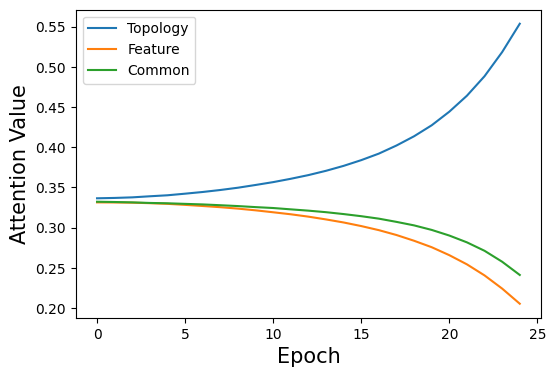

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming you have att_array_all as a tensor of shape (epochs, 3, 1)
# Extract the three rows into separate tensors
att1 = att_array_all[:, 0, 0].detach().numpy()
att2 = att_array_all[:, 1, 0].detach().numpy()
att3 = att_array_all[:, 2, 0].detach().numpy()

# Create an array of x values (e.g., epoch values)
x = range(epochs)

# Plot the three curves
plt.figure(figsize=(6, 4))
plt.plot(x, att1, label='Topology', linestyle='-')
plt.plot(x, att2, label='Feature', linestyle='-')
plt.plot(x, att3, label='Common', linestyle='-')

# Add labels and legend
plt.xlabel('Epoch',fontsize = 15)
plt.ylabel('Attention Value', fontsize = 15)
# plt.title(dataset + " L/C" + str(labelrate), fontsize = 15)
plt.legend()

# Show the plot
plt.show()



# Structural only

In [ ]:
model = SGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
att_array_all = torch.zeros((epochs, 2, 1))

for epoch in range(epochs):
    loss, acc_test, macro_f1, emb, att = train_s_att(model, epoch)
    att_array_all[epoch] = torch.mean(att, axis = 0)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 1.7732 atr: 0.3000 ate: 0.2650 f1te:0.2127
e:1 ltr: 1.7535 atr: 0.6000 ate: 0.4080 f1te:0.3804
e:2 ltr: 1.7378 atr: 0.7583 ate: 0.5300 f1te:0.5043
e:3 ltr: 1.7177 atr: 0.8750 ate: 0.6020 f1te:0.5688
e:4 ltr: 1.7024 atr: 0.9000 ate: 0.6430 f1te:0.6016
e:5 ltr: 1.6825 atr: 0.9167 ate: 0.6670 f1te:0.6236
e:6 ltr: 1.6643 atr: 0.8917 ate: 0.6760 f1te:0.6343
e:7 ltr: 1.6435 atr: 0.9000 ate: 0.6870 f1te:0.6450
e:8 ltr: 1.6202 atr: 0.9000 ate: 0.6910 f1te:0.6465
e:9 ltr: 1.5969 atr: 0.9000 ate: 0.7040 f1te:0.6583
e:10 ltr: 1.5693 atr: 0.9000 ate: 0.7100 f1te:0.6638
e:11 ltr: 1.5406 atr: 0.9000 ate: 0.7120 f1te:0.6643
e:12 ltr: 1.5073 atr: 0.9000 ate: 0.7130 f1te:0.6653
e:13 ltr: 1.4716 atr: 0.8917 ate: 0.7160 f1te:0.6684
e:14 ltr: 1.4337 atr: 0.9083 ate: 0.7140 f1te:0.6682
e:15 ltr: 1.3926 atr: 0.9000 ate: 0.7150 f1te:0.6693
e:16 ltr: 1.3407 atr: 0.9083 ate: 0.7160 f1te:0.6705
e:17 ltr: 1.2835 atr: 0.9083 ate: 0.7200 f1te:0.6740
e:18 ltr: 1.2226 atr: 0.9167 ate: 0.7210 f1te:0.6749
e:1

# Feature only

In [ ]:
model = FGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_f(model, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


# S, F

In [ ]:
model = sfGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_sf(model, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 1.7901 atr: 0.1500 ate: 0.2530 f1te:0.1004
e:1 ltr: 1.7740 atr: 0.2000 ate: 0.2810 f1te:0.1349
e:2 ltr: 1.7564 atr: 0.3083 ate: 0.3710 f1te:0.2771
e:3 ltr: 1.7408 atr: 0.5667 ate: 0.4910 f1te:0.4381
e:4 ltr: 1.7261 atr: 0.7500 ate: 0.5830 f1te:0.5413
e:5 ltr: 1.7087 atr: 0.8750 ate: 0.6400 f1te:0.5964
e:6 ltr: 1.6918 atr: 0.8583 ate: 0.6760 f1te:0.6316
e:7 ltr: 1.6749 atr: 0.8917 ate: 0.6970 f1te:0.6520
e:8 ltr: 1.6549 atr: 0.8750 ate: 0.7020 f1te:0.6582
e:9 ltr: 1.6336 atr: 0.8917 ate: 0.7070 f1te:0.6652
e:10 ltr: 1.6103 atr: 0.8750 ate: 0.7030 f1te:0.6635
e:11 ltr: 1.5881 atr: 0.8750 ate: 0.7110 f1te:0.6722
e:12 ltr: 1.5565 atr: 0.8833 ate: 0.7140 f1te:0.6753
e:13 ltr: 1.5272 atr: 0.8833 ate: 0.7150 f1te:0.6761
e:14 ltr: 1.4938 atr: 0.8833 ate: 0.7170 f1te:0.6780
e:15 ltr: 1.4544 atr: 0.9000 ate: 0.7150 f1te:0.6748
e:16 ltr: 1.4092 atr: 0.9000 ate: 0.7160 f1te:0.6759
e:17 ltr: 1.3700 atr: 0.9000 ate: 0.7150 f1te:0.6749
e:18 ltr: 1.3123 atr: 0.9083 ate: 0.7220 f1te:0.6813
e:1

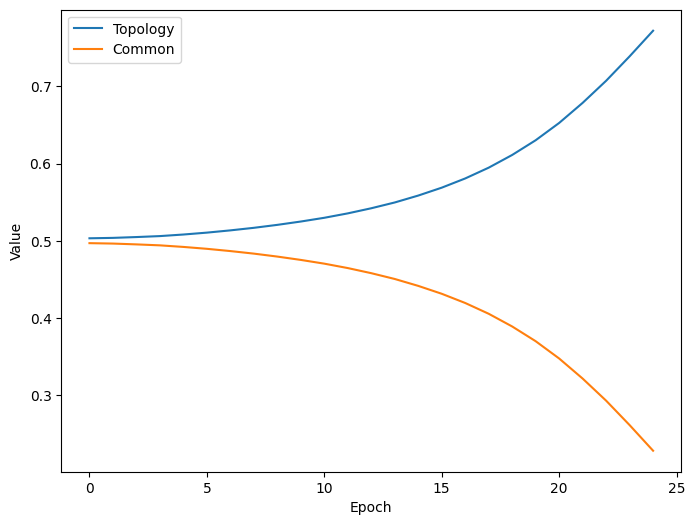

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming you have att_array_all as a tensor of shape (epochs, 3, 1)
# Extract the three rows into separate tensors
att1 = att_array_all[:, 0, 0].detach().numpy()
att2 = att_array_all[:, 1, 0].detach().numpy()

# Create an array of x values (e.g., epoch values)
x = range(epochs)

# Plot the three curves
plt.figure(figsize=(8, 6))
plt.plot(x, att1, label='Topology', linestyle='-')
plt.plot(x, att2, label='Common', linestyle='-')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

# [L/C 40]

In [ ]:

epochs = 25
lr = 0.0005
weight_decay = 5e-3
k = 7
nhid1 = 768
nhid2 = 128
dropout = 0.5
beta = 5e-8
theta = 0.001
no_cuda = False
no_seed = False
seed = 123

n = 3327
fdim = 3703
class_num = 6
structgraph_path = cite_path + 'citeseer.edge'
featuregraph_path = cite_path + 'knn/c'
feature_path = cite_path + 'citeseer.feature'
label_path = cite_path + 'citeseer.label'
test_path = cite_path + 'test40.txt'
train_path = cite_path + 'train40.txt'


In [ ]:
dataset = "citeseer"  # replace with your dataset name
labelrate = 40

# S, F

In [ ]:
model = sfGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_sf(model, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


NameError: ignored

#All

In [ ]:
sadj, fadj = load_graph(labelrate)
features, labels, idx_train, idx_test = load_data()


In [ ]:
model = SFGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:
acc_max = 0
f1_max = 0
epoch_max = 0
att_array_all = torch.zeros((epochs, 3, 1))
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb, att = train_att(model, epoch)
    # print(torch.mean(att, axis = 0))
    att_array_all[epoch] = torch.mean(att, axis = 0)

    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))

e:0 ltr: 1.7948 atr: 0.1667 ate: 0.1600 f1te:0.0460
e:1 ltr: 1.7813 atr: 0.1708 ate: 0.1680 f1te:0.0575
e:2 ltr: 1.7665 atr: 0.1958 ate: 0.2090 f1te:0.1083
e:3 ltr: 1.7529 atr: 0.2792 ate: 0.3070 f1te:0.2237
e:4 ltr: 1.7393 atr: 0.4292 ate: 0.4080 f1te:0.3415
e:5 ltr: 1.7262 atr: 0.5875 ate: 0.5220 f1te:0.4793
e:6 ltr: 1.7128 atr: 0.7208 ate: 0.6110 f1te:0.5699
e:7 ltr: 1.6991 atr: 0.7833 ate: 0.6660 f1te:0.6197
e:8 ltr: 1.6860 atr: 0.8125 ate: 0.6950 f1te:0.6461
e:9 ltr: 1.6717 atr: 0.8708 ate: 0.7170 f1te:0.6699
e:10 ltr: 1.6580 atr: 0.8750 ate: 0.7330 f1te:0.6898
e:11 ltr: 1.6429 atr: 0.8792 ate: 0.7460 f1te:0.7032
e:12 ltr: 1.6265 atr: 0.8625 ate: 0.7500 f1te:0.7059
e:13 ltr: 1.6120 atr: 0.8750 ate: 0.7550 f1te:0.7114
e:14 ltr: 1.5946 atr: 0.8583 ate: 0.7540 f1te:0.7077
e:15 ltr: 1.5764 atr: 0.8875 ate: 0.7540 f1te:0.7075
e:16 ltr: 1.5602 atr: 0.8750 ate: 0.7530 f1te:0.7053
e:17 ltr: 1.5414 atr: 0.8750 ate: 0.7510 f1te:0.7035
e:18 ltr: 1.5225 atr: 0.8792 ate: 0.7520 f1te:0.7057
e:1

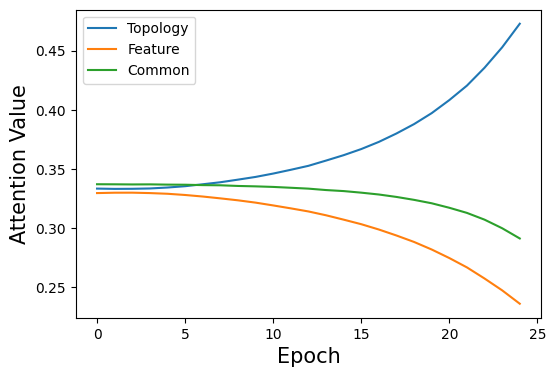

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming you have att_array_all as a tensor of shape (epochs, 3, 1)
# Extract the three rows into separate tensors
att1 = att_array_all[:, 0, 0].detach().numpy()
att2 = att_array_all[:, 1, 0].detach().numpy()
att3 = att_array_all[:, 2, 0].detach().numpy()

# Create an array of x values (e.g., epoch values)
x = range(epochs)

# Plot the three curves
plt.figure(figsize=(6, 4))
plt.plot(x, att1, label='Topology', linestyle='-')
plt.plot(x, att2, label='Feature', linestyle='-')
plt.plot(x, att3, label='Common', linestyle='-')

# Add labels and legend
plt.xlabel('Epoch',fontsize = 15)
plt.ylabel('Attention Value', fontsize = 15)
plt.legend()

# Show the plot
plt.show()


# Structural only

In [ ]:
model = SGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_s(model, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 1.7924 atr: 0.1833 ate: 0.3070 f1te:0.2171
e:1 ltr: 1.7730 atr: 0.3292 ate: 0.3970 f1te:0.2990
e:2 ltr: 1.7556 atr: 0.4792 ate: 0.4500 f1te:0.3429
e:3 ltr: 1.7339 atr: 0.5958 ate: 0.4870 f1te:0.3913
e:4 ltr: 1.7142 atr: 0.6708 ate: 0.5530 f1te:0.4825
e:5 ltr: 1.6967 atr: 0.7667 ate: 0.6200 f1te:0.5766
e:6 ltr: 1.6773 atr: 0.8083 ate: 0.6700 f1te:0.6364
e:7 ltr: 1.6552 atr: 0.8667 ate: 0.6910 f1te:0.6554
e:8 ltr: 1.6361 atr: 0.8792 ate: 0.7060 f1te:0.6705
e:9 ltr: 1.6165 atr: 0.9042 ate: 0.7160 f1te:0.6800
e:10 ltr: 1.5960 atr: 0.9083 ate: 0.7240 f1te:0.6864
e:11 ltr: 1.5734 atr: 0.9042 ate: 0.7300 f1te:0.6924
e:12 ltr: 1.5521 atr: 0.9042 ate: 0.7330 f1te:0.6952
e:13 ltr: 1.5306 atr: 0.9083 ate: 0.7340 f1te:0.6973
e:14 ltr: 1.5091 atr: 0.9083 ate: 0.7320 f1te:0.6943
e:15 ltr: 1.4855 atr: 0.9083 ate: 0.7320 f1te:0.6930
e:16 ltr: 1.4651 atr: 0.9125 ate: 0.7330 f1te:0.6939
e:17 ltr: 1.4400 atr: 0.9042 ate: 0.7370 f1te:0.6989
e:18 ltr: 1.4169 atr: 0.9083 ate: 0.7320 f1te:0.6944
e:1

# Feature only

In [ ]:
model = FGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_f(model, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 1.7937 atr: 0.1667 ate: 0.1840 f1te:0.0556
e:1 ltr: 1.7776 atr: 0.1875 ate: 0.2070 f1te:0.0959
e:2 ltr: 1.7608 atr: 0.2333 ate: 0.2700 f1te:0.1783
e:3 ltr: 1.7459 atr: 0.3375 ate: 0.4160 f1te:0.3582
e:4 ltr: 1.7320 atr: 0.4958 ate: 0.5870 f1te:0.5323
e:5 ltr: 1.7154 atr: 0.6750 ate: 0.6800 f1te:0.6321
e:6 ltr: 1.7010 atr: 0.7083 ate: 0.7150 f1te:0.6626
e:7 ltr: 1.6838 atr: 0.7625 ate: 0.7170 f1te:0.6656
e:8 ltr: 1.6669 atr: 0.7750 ate: 0.7210 f1te:0.6706
e:9 ltr: 1.6513 atr: 0.7958 ate: 0.7240 f1te:0.6747
e:10 ltr: 1.6334 atr: 0.7875 ate: 0.7200 f1te:0.6718
e:11 ltr: 1.6173 atr: 0.8042 ate: 0.7240 f1te:0.6753
e:12 ltr: 1.6000 atr: 0.7958 ate: 0.7250 f1te:0.6762
e:13 ltr: 1.5804 atr: 0.7917 ate: 0.7270 f1te:0.6780
e:14 ltr: 1.5630 atr: 0.7833 ate: 0.7280 f1te:0.6790
e:15 ltr: 1.5442 atr: 0.8000 ate: 0.7280 f1te:0.6805
e:16 ltr: 1.5258 atr: 0.8083 ate: 0.7290 f1te:0.6815
e:17 ltr: 1.5087 atr: 0.8042 ate: 0.7280 f1te:0.6806
e:18 ltr: 1.4906 atr: 0.8083 ate: 0.7290 f1te:0.6816
e:1

# [L/C 60]

In [ ]:

epochs = 25
lr = 0.0005
weight_decay = 5e-3
k = 7
nhid1 = 768
nhid2 = 128
dropout = 0.5
beta = 5e-8
theta = 0.001
no_cuda = False
no_seed = False
seed = 123


n = 3327
fdim = 3703
class_num = 6
structgraph_path = cite_path + 'citeseer.edge'
featuregraph_path = cite_path + 'knn/c'
feature_path = cite_path + 'citeseer.feature'
label_path = cite_path + 'citeseer.label'
test_path = cite_path + 'test60.txt'
train_path = cite_path + 'train60.txt'


In [ ]:
dataset = "citeseer"  # replace with your dataset name
labelrate = 60

In [ ]:
sadj, fadj = load_graph(labelrate)
features, labels, idx_train, idx_test = load_data()


# S, F

In [ ]:
model = sfGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_sf(model, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 1.7951 atr: 0.1472 ate: 0.1400 f1te:0.0672
e:1 ltr: 1.7775 atr: 0.1972 ate: 0.1730 f1te:0.0872
e:2 ltr: 1.7607 atr: 0.2611 ate: 0.2540 f1te:0.1946
e:3 ltr: 1.7458 atr: 0.3944 ate: 0.3860 f1te:0.3513
e:4 ltr: 1.7286 atr: 0.5556 ate: 0.5300 f1te:0.5070
e:5 ltr: 1.7116 atr: 0.6778 ate: 0.6140 f1te:0.5920
e:6 ltr: 1.6947 atr: 0.7417 ate: 0.6690 f1te:0.6421
e:7 ltr: 1.6783 atr: 0.7972 ate: 0.7050 f1te:0.6743
e:8 ltr: 1.6606 atr: 0.8278 ate: 0.7260 f1te:0.6928
e:9 ltr: 1.6410 atr: 0.8250 ate: 0.7380 f1te:0.7031
e:10 ltr: 1.6205 atr: 0.8528 ate: 0.7440 f1te:0.7106
e:11 ltr: 1.6006 atr: 0.8639 ate: 0.7440 f1te:0.7069
e:12 ltr: 1.5797 atr: 0.8556 ate: 0.7480 f1te:0.7076
e:13 ltr: 1.5519 atr: 0.8694 ate: 0.7500 f1te:0.7093
e:14 ltr: 1.5253 atr: 0.8639 ate: 0.7490 f1te:0.7082
e:15 ltr: 1.4954 atr: 0.8694 ate: 0.7490 f1te:0.7068
e:16 ltr: 1.4651 atr: 0.8750 ate: 0.7520 f1te:0.7111
e:17 ltr: 1.4294 atr: 0.8806 ate: 0.7510 f1te:0.7101
e:18 ltr: 1.3953 atr: 0.8722 ate: 0.7510 f1te:0.7097
e:1

# All

In [ ]:
model = SFGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:
acc_max = 0
f1_max = 0
epoch_max = 0
att_array_all = torch.zeros((epochs, 3, 1))

for epoch in range(epochs):
    loss, acc_test, macro_f1, emb, att = train_att(model, epoch)
    # print(torch.mean(att, axis = 0))
    att_array_all[epoch] = torch.mean(att, axis = 0)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 1.7943 atr: 0.1694 ate: 0.2270 f1te:0.1124
e:1 ltr: 1.7798 atr: 0.2389 ate: 0.2970 f1te:0.1751
e:2 ltr: 1.7667 atr: 0.3000 ate: 0.3760 f1te:0.2713
e:3 ltr: 1.7539 atr: 0.4722 ate: 0.4730 f1te:0.4032
e:4 ltr: 1.7422 atr: 0.5861 ate: 0.5700 f1te:0.5227
e:5 ltr: 1.7298 atr: 0.7194 ate: 0.6540 f1te:0.6145
e:6 ltr: 1.7167 atr: 0.7806 ate: 0.7050 f1te:0.6673
e:7 ltr: 1.7042 atr: 0.8083 ate: 0.7170 f1te:0.6798
e:8 ltr: 1.6916 atr: 0.8250 ate: 0.7300 f1te:0.6919
e:9 ltr: 1.6789 atr: 0.8361 ate: 0.7360 f1te:0.6979
e:10 ltr: 1.6651 atr: 0.8361 ate: 0.7370 f1te:0.6987
e:11 ltr: 1.6499 atr: 0.8333 ate: 0.7390 f1te:0.7006
e:12 ltr: 1.6370 atr: 0.8444 ate: 0.7350 f1te:0.6963
e:13 ltr: 1.6225 atr: 0.8444 ate: 0.7400 f1te:0.7012
e:14 ltr: 1.6061 atr: 0.8472 ate: 0.7390 f1te:0.7003
e:15 ltr: 1.5923 atr: 0.8528 ate: 0.7400 f1te:0.7027
e:16 ltr: 1.5770 atr: 0.8472 ate: 0.7430 f1te:0.7056
e:17 ltr: 1.5603 atr: 0.8472 ate: 0.7440 f1te:0.7071
e:18 ltr: 1.5444 atr: 0.8694 ate: 0.7440 f1te:0.7069
e:1

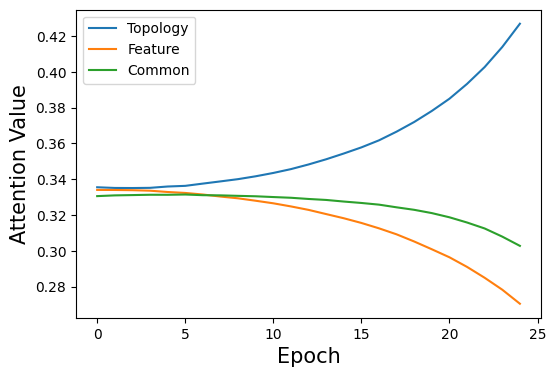

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming you have att_array_all as a tensor of shape (epochs, 3, 1)
# Extract the three rows into separate tensors
att1 = att_array_all[:, 0, 0].detach().numpy()
att2 = att_array_all[:, 1, 0].detach().numpy()
att3 = att_array_all[:, 2, 0].detach().numpy()

# Create an array of x values (e.g., epoch values)
x = range(epochs)

# Plot the three curves
plt.figure(figsize=(6, 4))
plt.plot(x, att1, label='Topology', linestyle='-')
plt.plot(x, att2, label='Feature', linestyle='-')
plt.plot(x, att3, label='Common', linestyle='-')

# Add labels and legend
plt.xlabel('Epoch',fontsize = 15)
plt.ylabel('Attention Value', fontsize = 15)
plt.legend()

# Show the plot
plt.show()


# Structural only

In [ ]:
model = SGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_s(model, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))

e:0 ltr: 1.7923 atr: 0.1611 ate: 0.2830 f1te:0.1824
e:1 ltr: 1.7747 atr: 0.3083 ate: 0.3910 f1te:0.2953
e:2 ltr: 1.7565 atr: 0.4583 ate: 0.4900 f1te:0.4244
e:3 ltr: 1.7390 atr: 0.6000 ate: 0.5980 f1te:0.5615
e:4 ltr: 1.7209 atr: 0.7611 ate: 0.6680 f1te:0.6365
e:5 ltr: 1.7021 atr: 0.8333 ate: 0.7020 f1te:0.6710
e:6 ltr: 1.6849 atr: 0.8556 ate: 0.7320 f1te:0.6996
e:7 ltr: 1.6667 atr: 0.8528 ate: 0.7380 f1te:0.7066
e:8 ltr: 1.6489 atr: 0.8750 ate: 0.7390 f1te:0.7075
e:9 ltr: 1.6311 atr: 0.8833 ate: 0.7420 f1te:0.7107
e:10 ltr: 1.6121 atr: 0.8806 ate: 0.7460 f1te:0.7147
e:11 ltr: 1.5932 atr: 0.8806 ate: 0.7450 f1te:0.7118
e:12 ltr: 1.5733 atr: 0.8806 ate: 0.7470 f1te:0.7137
e:13 ltr: 1.5544 atr: 0.8806 ate: 0.7480 f1te:0.7146
e:14 ltr: 1.5336 atr: 0.8889 ate: 0.7490 f1te:0.7158
e:15 ltr: 1.5162 atr: 0.8944 ate: 0.7490 f1te:0.7160
e:16 ltr: 1.4983 atr: 0.8917 ate: 0.7490 f1te:0.7160
e:17 ltr: 1.4828 atr: 0.8861 ate: 0.7460 f1te:0.7123
e:18 ltr: 1.4633 atr: 0.8944 ate: 0.7460 f1te:0.7124
e:1

# Feature only

In [ ]:
model = FGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_f(model, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 1.7930 atr: 0.1694 ate: 0.3240 f1te:0.2329
e:1 ltr: 1.7792 atr: 0.3361 ate: 0.5210 f1te:0.4330
e:2 ltr: 1.7647 atr: 0.5306 ate: 0.6280 f1te:0.5385
e:3 ltr: 1.7508 atr: 0.6083 ate: 0.6900 f1te:0.6005
e:4 ltr: 1.7388 atr: 0.6639 ate: 0.7100 f1te:0.6203
e:5 ltr: 1.7254 atr: 0.6694 ate: 0.7180 f1te:0.6442
e:6 ltr: 1.7112 atr: 0.7167 ate: 0.7220 f1te:0.6508
e:7 ltr: 1.6968 atr: 0.7167 ate: 0.7260 f1te:0.6668
e:8 ltr: 1.6837 atr: 0.7278 ate: 0.7280 f1te:0.6782
e:9 ltr: 1.6694 atr: 0.7528 ate: 0.7340 f1te:0.6864
e:10 ltr: 1.6539 atr: 0.7611 ate: 0.7340 f1te:0.6875
e:11 ltr: 1.6382 atr: 0.7528 ate: 0.7320 f1te:0.6886
e:12 ltr: 1.6223 atr: 0.7694 ate: 0.7310 f1te:0.6903
e:13 ltr: 1.6072 atr: 0.7750 ate: 0.7340 f1te:0.6942
e:14 ltr: 1.5916 atr: 0.7861 ate: 0.7300 f1te:0.6901
e:15 ltr: 1.5767 atr: 0.7917 ate: 0.7300 f1te:0.6913
e:16 ltr: 1.5614 atr: 0.7889 ate: 0.7290 f1te:0.6900
e:17 ltr: 1.5448 atr: 0.7944 ate: 0.7270 f1te:0.6882
e:18 ltr: 1.5302 atr: 0.8028 ate: 0.7260 f1te:0.6883
e:1

# gcn_citeseer

In [ ]:
sadj = load_graph_gcn(labelrate)
features, labels, idx_train, idx_test = load_data()


In [ ]:
# def __init__(self, nfeat, nhid, out, dropout):
model_gcn = GCN(nfeat = fdim,
            nhid = nhid1,
            out = class_num,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model_gcn.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model_gcn.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1 = train_gcn(model_gcn, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 0.2115 atr: 0.1167 ate: 0.1940 f1te:0.1331
e:1 ltr: -0.5001 atr: 0.4250 ate: 0.3090 f1te:0.2675
e:2 ltr: -1.1766 atr: 0.6667 ate: 0.3960 f1te:0.3554
e:3 ltr: -1.8600 atr: 0.7917 ate: 0.4510 f1te:0.4179
e:4 ltr: -2.5092 atr: 0.9083 ate: 0.4880 f1te:0.4582
e:5 ltr: -3.1785 atr: 0.9083 ate: 0.5140 f1te:0.4821
e:6 ltr: -3.8712 atr: 0.9333 ate: 0.5250 f1te:0.4944
e:7 ltr: -4.5254 atr: 0.9500 ate: 0.5420 f1te:0.5129
e:8 ltr: -5.2731 atr: 0.9500 ate: 0.5550 f1te:0.5238
e:9 ltr: -6.0224 atr: 0.9667 ate: 0.5770 f1te:0.5458
e:10 ltr: -6.6599 atr: 0.9583 ate: 0.5810 f1te:0.5507
e:11 ltr: -7.4028 atr: 0.9667 ate: 0.5880 f1te:0.5581
e:12 ltr: -8.2759 atr: 0.9500 ate: 0.5950 f1te:0.5648
e:13 ltr: -9.0401 atr: 0.9417 ate: 0.6010 f1te:0.5706
e:14 ltr: -9.9056 atr: 0.9583 ate: 0.6060 f1te:0.5748
e:15 ltr: -10.7265 atr: 0.9667 ate: 0.6080 f1te:0.5766
e:16 ltr: -11.4547 atr: 0.9417 ate: 0.6140 f1te:0.5818
e:17 ltr: -12.4914 atr: 0.9583 ate: 0.6160 f1te:0.5842
e:18 ltr: -13.2940 atr: 0.9667 ate: 

In [ ]:

epochs = 25
lr = 0.0005
weight_decay = 5e-3
k = 7
nhid1 = 768
nhid2 = 128
dropout = 0.5
beta = 5e-8
theta = 0.001
no_cuda = False
no_seed = False
seed = 123

n = 3327
fdim = 3703
class_num = 6
structgraph_path = cite_path + 'citeseer.edge'
featuregraph_path = cite_path + 'knn/c'
feature_path = cite_path + 'citeseer.feature'
label_path = cite_path + 'citeseer.label'
test_path = cite_path + 'test40.txt'
train_path = cite_path + 'train40.txt'


In [ ]:
dataset = "citeseer"  # replace with your dataset name
labelrate = 40

In [ ]:
sadj, fadj = load_graph(labelrate)
features, labels, idx_train, idx_test = load_data()


In [ ]:
# def __init__(self, nfeat, nhid, out, dropout):
model_gcn = GCN(nfeat = fdim,
            nhid = nhid1,
            out = class_num,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model_gcn.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model_gcn.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:
# 40

acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1 = train_gcn(model_gcn, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: -0.0328 atr: 0.1792 ate: 0.3060 f1te:0.2309
e:1 ltr: -0.7136 atr: 0.4208 ate: 0.4300 f1te:0.3553
e:2 ltr: -1.3697 atr: 0.6500 ate: 0.5060 f1te:0.4428
e:3 ltr: -1.9234 atr: 0.7458 ate: 0.5510 f1te:0.4931
e:4 ltr: -2.5914 atr: 0.8042 ate: 0.5980 f1te:0.5435
e:5 ltr: -3.2093 atr: 0.8500 ate: 0.6120 f1te:0.5589
e:6 ltr: -3.8903 atr: 0.8625 ate: 0.6230 f1te:0.5703
e:7 ltr: -4.5550 atr: 0.8667 ate: 0.6320 f1te:0.5795
e:8 ltr: -5.1954 atr: 0.8792 ate: 0.6380 f1te:0.5918
e:9 ltr: -5.8859 atr: 0.8875 ate: 0.6400 f1te:0.6001
e:10 ltr: -6.5837 atr: 0.8792 ate: 0.6460 f1te:0.6075
e:11 ltr: -7.3206 atr: 0.9042 ate: 0.6520 f1te:0.6152
e:12 ltr: -8.1150 atr: 0.8917 ate: 0.6580 f1te:0.6209
e:13 ltr: -8.8326 atr: 0.8833 ate: 0.6590 f1te:0.6217
e:14 ltr: -9.6899 atr: 0.8917 ate: 0.6630 f1te:0.6251
e:15 ltr: -10.4686 atr: 0.9042 ate: 0.6650 f1te:0.6266
e:16 ltr: -11.3027 atr: 0.8917 ate: 0.6690 f1te:0.6304
e:17 ltr: -12.1101 atr: 0.9000 ate: 0.6670 f1te:0.6285
e:18 ltr: -12.9706 atr: 0.8958 ate:

In [ ]:
# 60
epochs = 25
lr = 0.0005
weight_decay = 5e-3
k = 7
nhid1 = 768
nhid2 = 128
dropout = 0.5
beta = 5e-8
theta = 0.001
no_cuda = False
no_seed = False
seed = 123


n = 3327
fdim = 3703
class_num = 6
structgraph_path = cite_path + 'citeseer.edge'
featuregraph_path = cite_path + 'knn/c'
feature_path = cite_path + 'citeseer.feature'
label_path = cite_path + 'citeseer.label'
test_path = cite_path + 'test60.txt'
train_path = cite_path + 'train60.txt'


In [ ]:
dataset = "citeseer"  # replace with your dataset name
labelrate = 60

In [ ]:
sadj, fadj = load_graph(labelrate)
features, labels, idx_train, idx_test = load_data()


In [ ]:
# def __init__(self, nfeat, nhid, out, dropout):
model_gcn = GCN(nfeat = fdim,
            nhid = nhid1,
            out = class_num,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model_gcn.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model_gcn.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:

acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1 = train_gcn(model_gcn, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 0.0855 atr: 0.2083 ate: 0.3400 f1te:0.2476
e:1 ltr: -0.5230 atr: 0.3722 ate: 0.4640 f1te:0.4103
e:2 ltr: -1.1826 atr: 0.6000 ate: 0.5480 f1te:0.5109
e:3 ltr: -1.7760 atr: 0.7306 ate: 0.5990 f1te:0.5733
e:4 ltr: -2.4223 atr: 0.7944 ate: 0.6470 f1te:0.6247
e:5 ltr: -3.0592 atr: 0.8417 ate: 0.6630 f1te:0.6384
e:6 ltr: -3.6651 atr: 0.8722 ate: 0.6670 f1te:0.6413
e:7 ltr: -4.3340 atr: 0.8722 ate: 0.6780 f1te:0.6513
e:8 ltr: -5.0157 atr: 0.8806 ate: 0.6800 f1te:0.6531
e:9 ltr: -5.7039 atr: 0.9000 ate: 0.6840 f1te:0.6571
e:10 ltr: -6.4069 atr: 0.8917 ate: 0.6990 f1te:0.6710
e:11 ltr: -7.1667 atr: 0.9056 ate: 0.7080 f1te:0.6794
e:12 ltr: -7.8959 atr: 0.9167 ate: 0.7100 f1te:0.6815
e:13 ltr: -8.6619 atr: 0.9139 ate: 0.7100 f1te:0.6812
e:14 ltr: -9.4230 atr: 0.9000 ate: 0.7110 f1te:0.6808
e:15 ltr: -10.2613 atr: 0.9111 ate: 0.7130 f1te:0.6832
e:16 ltr: -11.1118 atr: 0.9056 ate: 0.7140 f1te:0.6840
e:17 ltr: -11.8794 atr: 0.9083 ate: 0.7140 f1te:0.6842
e:18 ltr: -12.7497 atr: 0.9000 ate: 

# Flickr

In [ ]:
flickr_path = '/content/drive/MyDrive/Colab Notebooks/Oxford_ACS/graph_representation_learning/miniproject/flickr/'

# 20

In [ ]:
dataset = 'flickr'
labelrate = 20
data_path = flickr_path

In [ ]:
# 20
epochs = 60
lr = 0.0003
weight_decay = 5e-4
k = 5
nhid1 = 512
nhid2 = 128
dropout = 0.5
beta = 1e-10
theta = 0.01
no_cuda = False
no_seed = False
seed = 123


n = 7575
fdim = 12047
class_num = 9
structgraph_path = data_path + dataset + '.edge'
featuregraph_path = data_path + 'knn/c'
feature_path = data_path + dataset + '.feature'
label_path = data_path + dataset + '.label'
test_path = data_path + 'test' + str(labelrate) + '.txt'
train_path = data_path + 'train' + str(labelrate) + '.txt'


In [ ]:
sadj, fadj = load_graph(labelrate)
features, labels, idx_train, idx_test = load_data()


# S, F

In [ ]:
model = sfGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_sf(model, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 2.1971 atr: 0.1111 ate: 0.1180 f1te:0.0302
e:1 ltr: 2.1853 atr: 0.1389 ate: 0.1280 f1te:0.0481
e:2 ltr: 2.1746 atr: 0.1778 ate: 0.1560 f1te:0.0925
e:3 ltr: 2.1619 atr: 0.2667 ate: 0.1870 f1te:0.1349
e:4 ltr: 2.1489 atr: 0.3667 ate: 0.2230 f1te:0.1842
e:5 ltr: 2.1378 atr: 0.4556 ate: 0.2750 f1te:0.2447
e:6 ltr: 2.1253 atr: 0.5389 ate: 0.3350 f1te:0.3120
e:7 ltr: 2.1106 atr: 0.6278 ate: 0.3790 f1te:0.3576
e:8 ltr: 2.0968 atr: 0.6944 ate: 0.4170 f1te:0.3972
e:9 ltr: 2.0818 atr: 0.7444 ate: 0.4690 f1te:0.4469
e:10 ltr: 2.0666 atr: 0.8000 ate: 0.5000 f1te:0.4755
e:11 ltr: 2.0490 atr: 0.8444 ate: 0.5340 f1te:0.5081
e:12 ltr: 2.0299 atr: 0.8722 ate: 0.5700 f1te:0.5396
e:13 ltr: 2.0118 atr: 0.9056 ate: 0.5930 f1te:0.5584
e:14 ltr: 1.9887 atr: 0.9167 ate: 0.6170 f1te:0.5799
e:15 ltr: 1.9643 atr: 0.9444 ate: 0.6260 f1te:0.5890
e:16 ltr: 1.9432 atr: 0.9389 ate: 0.6400 f1te:0.6028
e:17 ltr: 1.9123 atr: 0.9667 ate: 0.6530 f1te:0.6187
e:18 ltr: 1.8852 atr: 0.9722 ate: 0.6680 f1te:0.6378
e:1

# All

In [ ]:
model = SFGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:

acc_tests = []
macro_f1s = []

acc_max = 0
f1_max = 0
epoch_max = 0
att_array_all = torch.zeros((epochs, 3, 1))

for epoch in range(epochs):
    loss, acc_test, macro_f1, emb, att = train_att(model, epoch)
    # print(torch.mean(att, axis = 0))
    att_array_all[epoch] = torch.mean(att, axis = 0)
    acc_tests.append(acc_test)
    macro_f1s.append(macro_f1)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 2.1998 atr: 0.1000 ate: 0.1260 f1te:0.0322
e:1 ltr: 2.1905 atr: 0.1167 ate: 0.1290 f1te:0.0377
e:2 ltr: 2.1799 atr: 0.1667 ate: 0.1320 f1te:0.0430
e:3 ltr: 2.1706 atr: 0.1833 ate: 0.1430 f1te:0.0638
e:4 ltr: 2.1614 atr: 0.2222 ate: 0.1560 f1te:0.0863
e:5 ltr: 2.1517 atr: 0.3000 ate: 0.1690 f1te:0.1065
e:6 ltr: 2.1415 atr: 0.3333 ate: 0.1960 f1te:0.1486
e:7 ltr: 2.1330 atr: 0.3889 ate: 0.2270 f1te:0.1917
e:8 ltr: 2.1220 atr: 0.4778 ate: 0.2500 f1te:0.2214
e:9 ltr: 2.1105 atr: 0.5611 ate: 0.2870 f1te:0.2690
e:10 ltr: 2.0999 atr: 0.6000 ate: 0.3340 f1te:0.3220
e:11 ltr: 2.0870 atr: 0.6667 ate: 0.3660 f1te:0.3552
e:12 ltr: 2.0752 atr: 0.6944 ate: 0.3970 f1te:0.3900
e:13 ltr: 2.0614 atr: 0.6889 ate: 0.4260 f1te:0.4222
e:14 ltr: 2.0463 atr: 0.7611 ate: 0.4520 f1te:0.4433
e:15 ltr: 2.0310 atr: 0.7722 ate: 0.4790 f1te:0.4695
e:16 ltr: 2.0147 atr: 0.8278 ate: 0.5030 f1te:0.4907
e:17 ltr: 1.9987 atr: 0.8222 ate: 0.5180 f1te:0.5038
e:18 ltr: 1.9802 atr: 0.8556 ate: 0.5450 f1te:0.5318
e:1

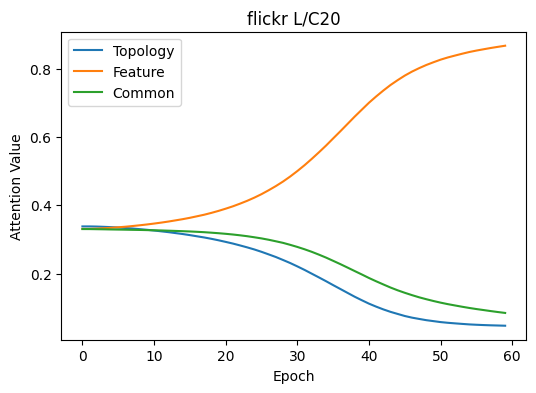

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming you have att_array_all as a tensor of shape (epochs, 3, 1)
# Extract the three rows into separate tensors
att1 = att_array_all[:, 0, 0].detach().numpy()
att2 = att_array_all[:, 1, 0].detach().numpy()
att3 = att_array_all[:, 2, 0].detach().numpy()

# Create an array of x values (e.g., epoch values)
x = range(epochs)

# Plot the three curves
plt.figure(figsize=(6, 4))
plt.plot(x, att1, label='Topology', linestyle='-')
plt.plot(x, att2, label='Feature', linestyle='-')
plt.plot(x, att3, label='Common', linestyle='-')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Attention Value')
plt.title(dataset + " L/C" + str(labelrate))
plt.legend()

# Show the plot
plt.show()


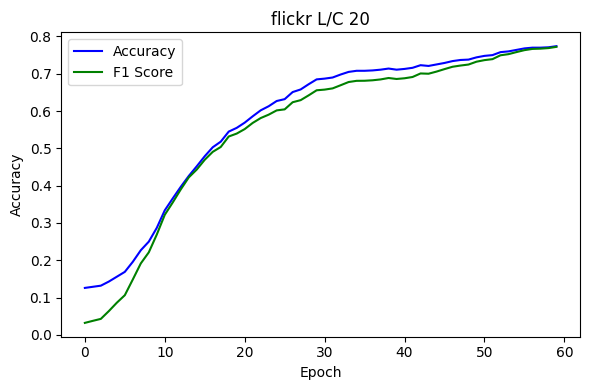

In [ ]:

# Plotting
plt.figure(figsize=(6, 4))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc_tests, label='Accuracy', color='blue')
plt.plot(range(epochs), macro_f1s, label='F1 Score', color='green')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(dataset + ' L/C ' + str(labelrate))
plt.legend()

plt.tight_layout()
plt.show()

# Structural only

In [ ]:
model = SGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:
acc_tests = []
macro_f1s = []

acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_s(model, epoch)
    acc_tests.append(acc_test)
    macro_f1s.append(macro_f1)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 2.1986 atr: 0.1222 ate: 0.1110 f1te:0.0397
e:1 ltr: 2.1939 atr: 0.1667 ate: 0.1350 f1te:0.0530
e:2 ltr: 2.1885 atr: 0.1833 ate: 0.1570 f1te:0.0655
e:3 ltr: 2.1838 atr: 0.1944 ate: 0.1640 f1te:0.0785
e:4 ltr: 2.1787 atr: 0.2333 ate: 0.1710 f1te:0.0935
e:5 ltr: 2.1737 atr: 0.2667 ate: 0.1970 f1te:0.1348
e:6 ltr: 2.1680 atr: 0.3889 ate: 0.2190 f1te:0.1664
e:7 ltr: 2.1626 atr: 0.4444 ate: 0.2490 f1te:0.1977
e:8 ltr: 2.1574 atr: 0.4944 ate: 0.2690 f1te:0.2156
e:9 ltr: 2.1519 atr: 0.6056 ate: 0.3010 f1te:0.2453
e:10 ltr: 2.1446 atr: 0.6556 ate: 0.3240 f1te:0.2645
e:11 ltr: 2.1379 atr: 0.7000 ate: 0.3510 f1te:0.2976
e:12 ltr: 2.1304 atr: 0.7056 ate: 0.3670 f1te:0.3254
e:13 ltr: 2.1238 atr: 0.7556 ate: 0.3720 f1te:0.3395
e:14 ltr: 2.1169 atr: 0.7389 ate: 0.3720 f1te:0.3440
e:15 ltr: 2.1069 atr: 0.7611 ate: 0.3680 f1te:0.3483
e:16 ltr: 2.0984 atr: 0.7833 ate: 0.3700 f1te:0.3576
e:17 ltr: 2.0888 atr: 0.7778 ate: 0.3730 f1te:0.3635
e:18 ltr: 2.0767 atr: 0.7944 ate: 0.3740 f1te:0.3664
e:1

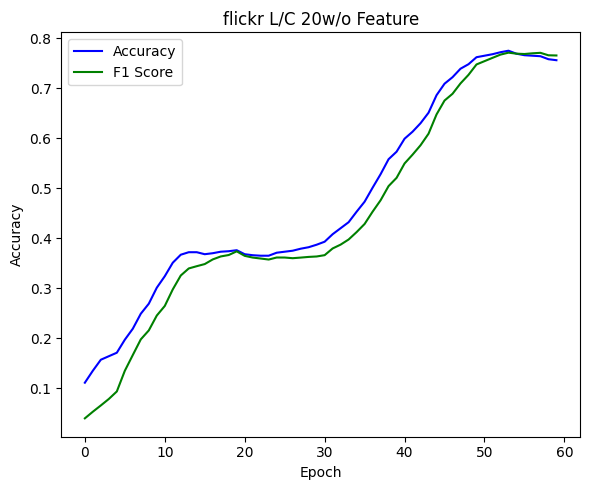

In [ ]:

# Plotting
plt.figure(figsize=(6, 5))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc_tests, label='Accuracy', color='blue')
plt.plot(range(epochs), macro_f1s, label='F1 Score', color='green')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(dataset + ' L/C ' + str(labelrate) + 'w/o Feature')
plt.legend()

# # Plot F1 score
# plt.subplot(1, 2, 2)
# plt.plot(range(epochs), macro_f1s, label='Macro F1 Score', color='green')
# plt.xlabel('Epoch')
# plt.ylabel('Macro F1 Score')
# plt.title('Macro F1 Score per Epoch')
# plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model = FGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:

acc_tests = []
macro_f1s = []

acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_f(model, epoch)
    acc_tests.append(acc_test)
    macro_f1s.append(macro_f1)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 2.1994 atr: 0.1111 ate: 0.1150 f1te:0.0231
e:1 ltr: 2.1841 atr: 0.1167 ate: 0.1190 f1te:0.0309
e:2 ltr: 2.1681 atr: 0.1500 ate: 0.1360 f1te:0.0636
e:3 ltr: 2.1516 atr: 0.2500 ate: 0.1640 f1te:0.1100
e:4 ltr: 2.1373 atr: 0.3444 ate: 0.2130 f1te:0.1833
e:5 ltr: 2.1227 atr: 0.4833 ate: 0.2790 f1te:0.2691
e:6 ltr: 2.1063 atr: 0.6889 ate: 0.3540 f1te:0.3568
e:7 ltr: 2.0897 atr: 0.7667 ate: 0.4510 f1te:0.4538
e:8 ltr: 2.0724 atr: 0.8333 ate: 0.5040 f1te:0.5063
e:9 ltr: 2.0546 atr: 0.8778 ate: 0.5630 f1te:0.5622
e:10 ltr: 2.0367 atr: 0.8889 ate: 0.6040 f1te:0.5954
e:11 ltr: 2.0183 atr: 0.9222 ate: 0.6300 f1te:0.6168
e:12 ltr: 1.9989 atr: 0.9389 ate: 0.6490 f1te:0.6321
e:13 ltr: 1.9793 atr: 0.9778 ate: 0.6670 f1te:0.6431
e:14 ltr: 1.9585 atr: 0.9667 ate: 0.6780 f1te:0.6522
e:15 ltr: 1.9362 atr: 0.9833 ate: 0.6930 f1te:0.6623
e:16 ltr: 1.9137 atr: 0.9889 ate: 0.6930 f1te:0.6608
e:17 ltr: 1.8887 atr: 0.9889 ate: 0.7020 f1te:0.6682
e:18 ltr: 1.8617 atr: 0.9944 ate: 0.7060 f1te:0.6719
e:1

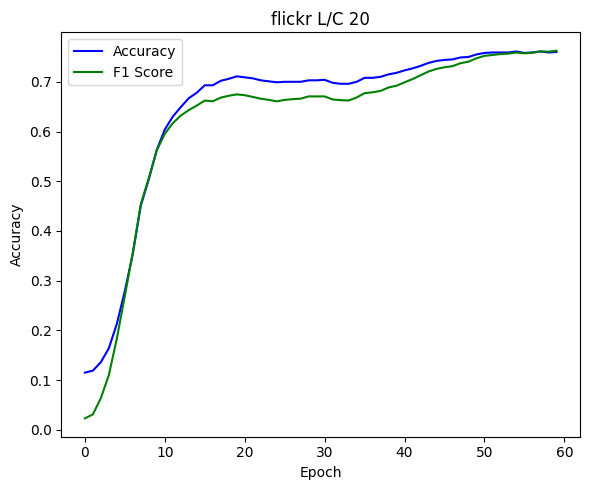

In [ ]:

# Plotting
plt.figure(figsize=(6, 5))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc_tests, label='Accuracy', color='blue')
plt.plot(range(epochs), macro_f1s, label='F1 Score', color='green')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(dataset + ' L/C ' + str(labelrate))
plt.legend()

# # Plot F1 score
# plt.subplot(1, 2, 2)
# plt.plot(range(epochs), macro_f1s, label='Macro F1 Score', color='green')
# plt.xlabel('Epoch')
# plt.ylabel('Macro F1 Score')
# plt.title('Macro F1 Score per Epoch')
# plt.legend()

plt.tight_layout()
plt.show()

# 40

In [ ]:
dataset = 'flickr'
labelrate = 40
data_path = flickr_path

In [ ]:
# 40
epochs = 40
lr = 0.0005
weight_decay = 1e-5
k = 5
nhid1 = 512
nhid2 = 128
dropout = 0.5
beta = 1e-10
theta = 0.01
no_cuda = False
no_seed = False
seed = 123


n = 7575
fdim = 12047
class_num = 9
structgraph_path = data_path + dataset + '.edge'
featuregraph_path = data_path + 'knn/c'
feature_path = data_path + dataset + '.feature'
label_path = data_path + dataset + '.label'
test_path = data_path + 'test' + str(labelrate) + '.txt'
train_path = data_path + 'train' + str(labelrate) + '.txt'


In [ ]:
sadj, fadj = load_graph(labelrate)
features, labels, idx_train, idx_test = load_data()


# S, F

In [ ]:
model = sfGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_sf(model, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 2.1997 atr: 0.1139 ate: 0.1950 f1te:0.0797
e:1 ltr: 2.1762 atr: 0.2222 ate: 0.2650 f1te:0.1668
e:2 ltr: 2.1518 atr: 0.3361 ate: 0.3520 f1te:0.2812
e:3 ltr: 2.1257 atr: 0.5000 ate: 0.4580 f1te:0.4017
e:4 ltr: 2.0977 atr: 0.6389 ate: 0.5510 f1te:0.5155
e:5 ltr: 2.0689 atr: 0.7611 ate: 0.6050 f1te:0.5780
e:6 ltr: 2.0335 atr: 0.8472 ate: 0.6410 f1te:0.6162
e:7 ltr: 1.9965 atr: 0.8889 ate: 0.6690 f1te:0.6505
e:8 ltr: 1.9537 atr: 0.9056 ate: 0.6920 f1te:0.6786
e:9 ltr: 1.9061 atr: 0.9417 ate: 0.7100 f1te:0.6990
e:10 ltr: 1.8537 atr: 0.9583 ate: 0.7230 f1te:0.7138
e:11 ltr: 1.7931 atr: 0.9639 ate: 0.7240 f1te:0.7136
e:12 ltr: 1.7276 atr: 0.9722 ate: 0.7410 f1te:0.7306
e:13 ltr: 1.6536 atr: 0.9694 ate: 0.7500 f1te:0.7380
e:14 ltr: 1.5754 atr: 0.9778 ate: 0.7530 f1te:0.7396
e:15 ltr: 1.4909 atr: 0.9806 ate: 0.7570 f1te:0.7419
e:16 ltr: 1.4139 atr: 0.9806 ate: 0.7610 f1te:0.7445
e:17 ltr: 1.3247 atr: 0.9778 ate: 0.7620 f1te:0.7442
e:18 ltr: 1.2468 atr: 0.9778 ate: 0.7660 f1te:0.7490
e:1

# All

In [ ]:
model = SFGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:

acc_tests = []
macro_f1s = []

acc_max = 0
f1_max = 0
epoch_max = 0
att_array_all = torch.zeros((epochs, 3, 1))

for epoch in range(epochs):
    loss, acc_test, macro_f1, emb, att = train_att(model, epoch)
    # print(torch.mean(att, axis = 0))
    att_array_all[epoch] = torch.mean(att, axis = 0)
    acc_tests.append(acc_test)
    macro_f1s.append(macro_f1)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 2.2006 atr: 0.1056 ate: 0.2090 f1te:0.0930
e:1 ltr: 2.1768 atr: 0.2194 ate: 0.2350 f1te:0.1081
e:2 ltr: 2.1545 atr: 0.2861 ate: 0.2710 f1te:0.1948
e:3 ltr: 2.1305 atr: 0.3972 ate: 0.3470 f1te:0.3159
e:4 ltr: 2.1067 atr: 0.5278 ate: 0.4020 f1te:0.3910
e:5 ltr: 2.0791 atr: 0.6861 ate: 0.4820 f1te:0.4855
e:6 ltr: 2.0511 atr: 0.7611 ate: 0.5370 f1te:0.5395
e:7 ltr: 2.0179 atr: 0.8306 ate: 0.5980 f1te:0.5996
e:8 ltr: 1.9835 atr: 0.8917 ate: 0.6480 f1te:0.6470
e:9 ltr: 1.9450 atr: 0.9389 ate: 0.6970 f1te:0.6921
e:10 ltr: 1.9027 atr: 0.9639 ate: 0.7330 f1te:0.7255
e:11 ltr: 1.8585 atr: 0.9778 ate: 0.7570 f1te:0.7464
e:12 ltr: 1.8091 atr: 0.9861 ate: 0.7720 f1te:0.7616
e:13 ltr: 1.7532 atr: 0.9944 ate: 0.7810 f1te:0.7714
e:14 ltr: 1.6947 atr: 0.9889 ate: 0.7850 f1te:0.7757
e:15 ltr: 1.6308 atr: 0.9944 ate: 0.7880 f1te:0.7792
e:16 ltr: 1.5600 atr: 0.9917 ate: 0.7980 f1te:0.7894
e:17 ltr: 1.4855 atr: 0.9917 ate: 0.8010 f1te:0.7931
e:18 ltr: 1.4088 atr: 0.9917 ate: 0.8030 f1te:0.7951
e:1

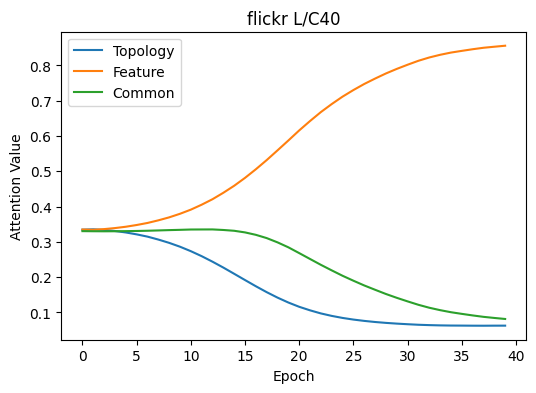

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming you have att_array_all as a tensor of shape (epochs, 3, 1)
# Extract the three rows into separate tensors
att1 = att_array_all[:, 0, 0].detach().numpy()
att2 = att_array_all[:, 1, 0].detach().numpy()
att3 = att_array_all[:, 2, 0].detach().numpy()

# Create an array of x values (e.g., epoch values)
x = range(epochs)

# Plot the three curves
plt.figure(figsize=(6, 4))
plt.plot(x, att1, label='Topology', linestyle='-')
plt.plot(x, att2, label='Feature', linestyle='-')
plt.plot(x, att3, label='Common', linestyle='-')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Attention Value')
plt.title(dataset + " L/C" + str(labelrate))
plt.legend()

# Show the plot
plt.show()


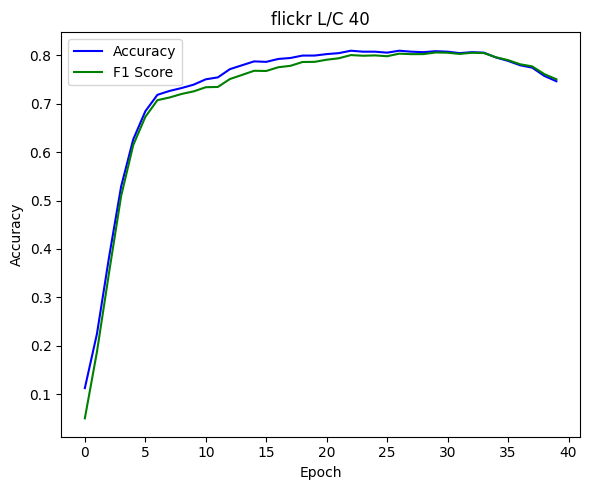

In [ ]:

# Plotting
plt.figure(figsize=(6, 5))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc_tests, label='Accuracy', color='blue')
plt.plot(range(epochs), macro_f1s, label='F1 Score', color='green')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(dataset + ' L/C ' + str(labelrate))
plt.legend()


plt.tight_layout()
plt.show()

# Structural only

In [ ]:
model = SGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:
acc_tests = []
macro_f1s = []

acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_s(model, epoch)
    acc_tests.append(acc_test)
    macro_f1s.append(macro_f1)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 2.1990 atr: 0.1241 ate: 0.1570 f1te:0.0752
e:1 ltr: 2.1919 atr: 0.1722 ate: 0.2360 f1te:0.1493
e:2 ltr: 2.1845 atr: 0.2870 ate: 0.2870 f1te:0.1993
e:3 ltr: 2.1767 atr: 0.3574 ate: 0.3090 f1te:0.2324
e:4 ltr: 2.1693 atr: 0.4037 ate: 0.3400 f1te:0.2810
e:5 ltr: 2.1612 atr: 0.4407 ate: 0.3870 f1te:0.3307
e:6 ltr: 2.1522 atr: 0.4852 ate: 0.4300 f1te:0.3760
e:7 ltr: 2.1430 atr: 0.5333 ate: 0.4530 f1te:0.3968
e:8 ltr: 2.1321 atr: 0.5630 ate: 0.4610 f1te:0.3956
e:9 ltr: 2.1197 atr: 0.5963 ate: 0.4680 f1te:0.4053
e:10 ltr: 2.1064 atr: 0.6352 ate: 0.4840 f1te:0.4298
e:11 ltr: 2.0917 atr: 0.6389 ate: 0.4910 f1te:0.4462
e:12 ltr: 2.0737 atr: 0.6574 ate: 0.4950 f1te:0.4529
e:13 ltr: 2.0541 atr: 0.6778 ate: 0.4950 f1te:0.4505
e:14 ltr: 2.0324 atr: 0.6796 ate: 0.4940 f1te:0.4473
e:15 ltr: 2.0075 atr: 0.6926 ate: 0.4940 f1te:0.4472
e:16 ltr: 1.9825 atr: 0.6852 ate: 0.4970 f1te:0.4456
e:17 ltr: 1.9511 atr: 0.6889 ate: 0.4990 f1te:0.4496
e:18 ltr: 1.9194 atr: 0.6944 ate: 0.5080 f1te:0.4590
e:1

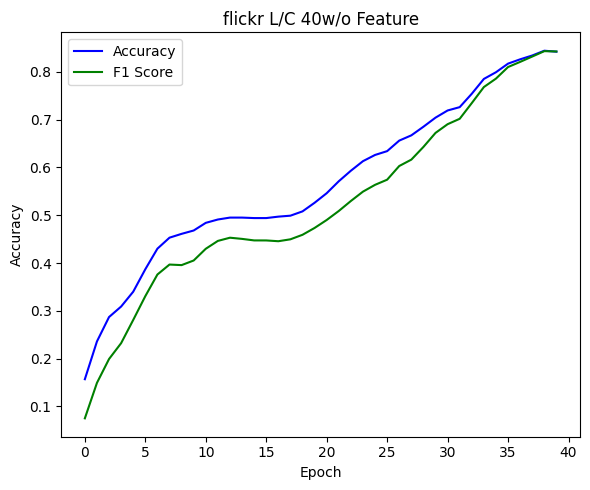

In [ ]:

# Plotting
plt.figure(figsize=(6, 5))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc_tests, label='Accuracy', color='blue')
plt.plot(range(epochs), macro_f1s, label='F1 Score', color='green')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(dataset + ' L/C ' + str(labelrate) + 'w/o Feature')
plt.legend()

# # Plot F1 score
# plt.subplot(1, 2, 2)
# plt.plot(range(epochs), macro_f1s, label='Macro F1 Score', color='green')
# plt.xlabel('Epoch')
# plt.ylabel('Macro F1 Score')
# plt.title('Macro F1 Score per Epoch')
# plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model = FGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:

acc_tests = []
macro_f1s = []

acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_f(model, epoch)
    acc_tests.append(acc_test)
    macro_f1s.append(macro_f1)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 2.1994 atr: 0.1204 ate: 0.1220 f1te:0.0779
e:1 ltr: 2.1779 atr: 0.2185 ate: 0.2900 f1te:0.2979
e:2 ltr: 2.1560 atr: 0.4426 ate: 0.4490 f1te:0.4381
e:3 ltr: 2.1351 atr: 0.6389 ate: 0.5460 f1te:0.5213
e:4 ltr: 2.1127 atr: 0.7444 ate: 0.6160 f1te:0.5835
e:5 ltr: 2.0904 atr: 0.8204 ate: 0.6540 f1te:0.6283
e:6 ltr: 2.0649 atr: 0.8481 ate: 0.6720 f1te:0.6525
e:7 ltr: 2.0385 atr: 0.8685 ate: 0.6780 f1te:0.6643
e:8 ltr: 2.0101 atr: 0.8778 ate: 0.6900 f1te:0.6751
e:9 ltr: 1.9780 atr: 0.8944 ate: 0.6990 f1te:0.6828
e:10 ltr: 1.9439 atr: 0.9056 ate: 0.7100 f1te:0.6917
e:11 ltr: 1.9085 atr: 0.9185 ate: 0.7230 f1te:0.7046
e:12 ltr: 1.8707 atr: 0.9241 ate: 0.7370 f1te:0.7166
e:13 ltr: 1.8265 atr: 0.9278 ate: 0.7400 f1te:0.7180
e:14 ltr: 1.7810 atr: 0.9296 ate: 0.7440 f1te:0.7214
e:15 ltr: 1.7324 atr: 0.9333 ate: 0.7530 f1te:0.7315
e:16 ltr: 1.6782 atr: 0.9389 ate: 0.7580 f1te:0.7366
e:17 ltr: 1.6252 atr: 0.9444 ate: 0.7650 f1te:0.7445
e:18 ltr: 1.5636 atr: 0.9370 ate: 0.7710 f1te:0.7525
e:1

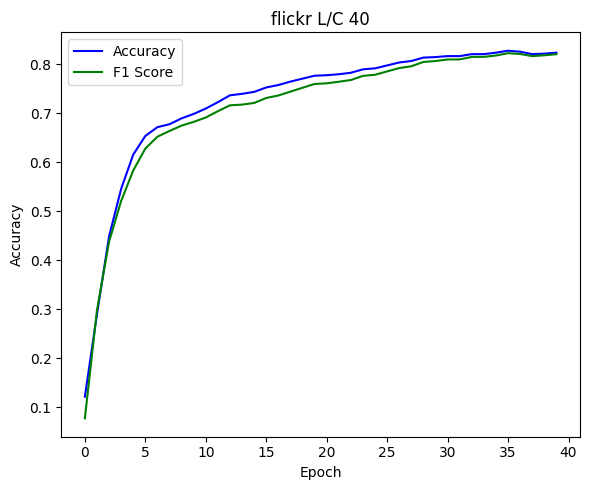

In [ ]:

# Plotting
plt.figure(figsize=(6, 5))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc_tests, label='Accuracy', color='blue')
plt.plot(range(epochs), macro_f1s, label='F1 Score', color='green')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(dataset + ' L/C ' + str(labelrate))
plt.legend()

# # Plot F1 score
# plt.subplot(1, 2, 2)
# plt.plot(range(epochs), macro_f1s, label='Macro F1 Score', color='green')
# plt.xlabel('Epoch')
# plt.ylabel('Macro F1 Score')
# plt.title('Macro F1 Score per Epoch')
# plt.legend()

plt.tight_layout()
plt.show()

# 60

In [ ]:
dataset = 'flickr'
labelrate = 60
data_path = flickr_path

In [ ]:
# 60
epochs = 40
lr = 0.0005
weight_decay = 5e-4
k = 5
nhid1 = 512
nhid2 = 128
dropout = 0.5
beta = 1e-10
theta = 0.01
no_cuda = False
no_seed = False
seed = 123


n = 7575
fdim = 12047
class_num = 9
structgraph_path = data_path + dataset + '.edge'
featuregraph_path = data_path + 'knn/c'
feature_path = data_path + dataset + '.feature'
label_path = data_path + dataset + '.label'
test_path = data_path + 'test' + str(labelrate) + '.txt'
train_path = data_path + 'train' + str(labelrate) + '.txt'


In [ ]:
sadj, fadj = load_graph(labelrate)
features, labels, idx_train, idx_test = load_data()


# S, F

In [ ]:
model = sfGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_sf(model, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 2.1978 atr: 0.1111 ate: 0.1290 f1te:0.0500
e:1 ltr: 2.1813 atr: 0.1463 ate: 0.1530 f1te:0.0847
e:2 ltr: 2.1654 atr: 0.2111 ate: 0.2120 f1te:0.1647
e:3 ltr: 2.1473 atr: 0.3148 ate: 0.2550 f1te:0.2176
e:4 ltr: 2.1305 atr: 0.3852 ate: 0.3190 f1te:0.2984
e:5 ltr: 2.1107 atr: 0.4852 ate: 0.3890 f1te:0.3847
e:6 ltr: 2.0896 atr: 0.5963 ate: 0.4540 f1te:0.4555
e:7 ltr: 2.0660 atr: 0.7037 ate: 0.5220 f1te:0.5251
e:8 ltr: 2.0412 atr: 0.7519 ate: 0.5900 f1te:0.5865
e:9 ltr: 2.0120 atr: 0.7926 ate: 0.6420 f1te:0.6349
e:10 ltr: 1.9816 atr: 0.8574 ate: 0.6740 f1te:0.6648
e:11 ltr: 1.9465 atr: 0.8926 ate: 0.7100 f1te:0.6979
e:12 ltr: 1.9093 atr: 0.9130 ate: 0.7380 f1te:0.7229
e:13 ltr: 1.8667 atr: 0.9370 ate: 0.7570 f1te:0.7448
e:14 ltr: 1.8204 atr: 0.9407 ate: 0.7820 f1te:0.7713
e:15 ltr: 1.7683 atr: 0.9444 ate: 0.7900 f1te:0.7795
e:16 ltr: 1.7140 atr: 0.9426 ate: 0.7960 f1te:0.7862
e:17 ltr: 1.6492 atr: 0.9519 ate: 0.7980 f1te:0.7888
e:18 ltr: 1.5847 atr: 0.9593 ate: 0.7980 f1te:0.7897
e:1

# All

In [ ]:
model = SFGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:

acc_tests = []
macro_f1s = []

acc_max = 0
f1_max = 0
epoch_max = 0
att_array_all = torch.zeros((epochs, 3, 1))

for epoch in range(epochs):
    loss, acc_test, macro_f1, emb, att = train_att(model, epoch)
    # print(torch.mean(att, axis = 0))
    att_array_all[epoch] = torch.mean(att, axis = 0)
    acc_tests.append(acc_test)
    macro_f1s.append(macro_f1)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 2.1977 atr: 0.1111 ate: 0.1310 f1te:0.0498
e:1 ltr: 2.1855 atr: 0.1556 ate: 0.2170 f1te:0.1575
e:2 ltr: 2.1728 atr: 0.3019 ate: 0.3280 f1te:0.2695
e:3 ltr: 2.1595 atr: 0.4259 ate: 0.4200 f1te:0.3618
e:4 ltr: 2.1467 atr: 0.5259 ate: 0.4930 f1te:0.4313
e:5 ltr: 2.1321 atr: 0.6333 ate: 0.5620 f1te:0.5031
e:6 ltr: 2.1174 atr: 0.6926 ate: 0.6110 f1te:0.5522
e:7 ltr: 2.0997 atr: 0.7407 ate: 0.6370 f1te:0.5793
e:8 ltr: 2.0818 atr: 0.7593 ate: 0.6640 f1te:0.6094
e:9 ltr: 2.0595 atr: 0.7981 ate: 0.6760 f1te:0.6147
e:10 ltr: 2.0369 atr: 0.8111 ate: 0.6870 f1te:0.6264
e:11 ltr: 2.0105 atr: 0.8296 ate: 0.6960 f1te:0.6343
e:12 ltr: 1.9826 atr: 0.8500 ate: 0.7120 f1te:0.6666
e:13 ltr: 1.9495 atr: 0.8685 ate: 0.7190 f1te:0.6767
e:14 ltr: 1.9136 atr: 0.8870 ate: 0.7330 f1te:0.6981
e:15 ltr: 1.8760 atr: 0.8963 ate: 0.7450 f1te:0.7166
e:16 ltr: 1.8288 atr: 0.9111 ate: 0.7550 f1te:0.7301
e:17 ltr: 1.7790 atr: 0.9148 ate: 0.7600 f1te:0.7347
e:18 ltr: 1.7233 atr: 0.9204 ate: 0.7610 f1te:0.7382
e:1

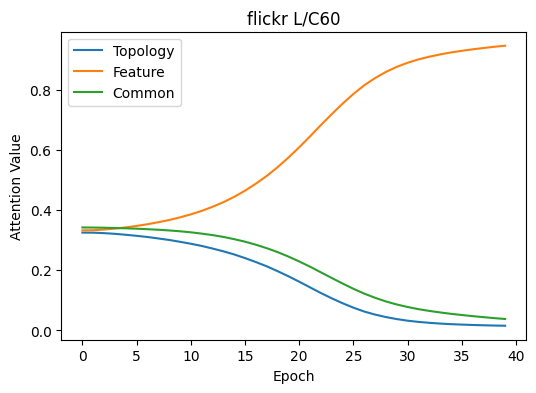

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming you have att_array_all as a tensor of shape (epochs, 3, 1)
# Extract the three rows into separate tensors
att1 = att_array_all[:, 0, 0].detach().numpy()
att2 = att_array_all[:, 1, 0].detach().numpy()
att3 = att_array_all[:, 2, 0].detach().numpy()

# Create an array of x values (e.g., epoch values)
x = range(epochs)

# Plot the three curves
plt.figure(figsize=(6, 4))
plt.plot(x, att1, label='Topology', linestyle='-')
plt.plot(x, att2, label='Feature', linestyle='-')
plt.plot(x, att3, label='Common', linestyle='-')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Attention Value')
plt.title(dataset + " L/C" + str(labelrate))
plt.legend()

# Show the plot
plt.show()


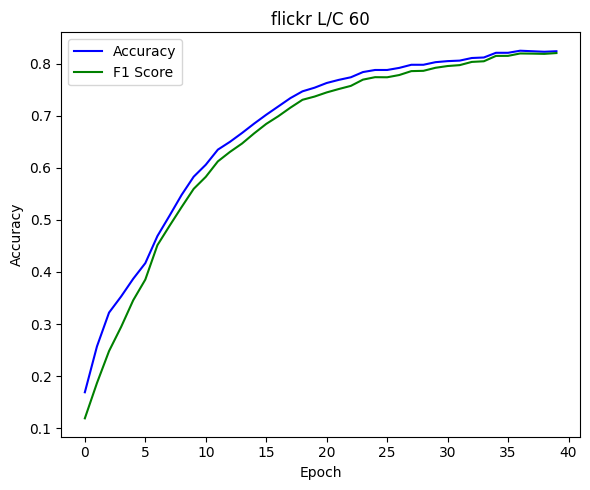

In [ ]:

# Plotting
plt.figure(figsize=(6, 5))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc_tests, label='Accuracy', color='blue')
plt.plot(range(epochs), macro_f1s, label='F1 Score', color='green')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(dataset + ' L/C ' + str(labelrate))
plt.legend()


plt.tight_layout()
plt.show()

# Structural only

In [ ]:
model = SGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:
acc_tests = []
macro_f1s = []

acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_s(model, epoch)
    acc_tests.append(acc_test)
    macro_f1s.append(macro_f1)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 2.1989 atr: 0.1093 ate: 0.0940 f1te:0.0208
e:1 ltr: 2.1917 atr: 0.1130 ate: 0.1140 f1te:0.0557
e:2 ltr: 2.1839 atr: 0.1722 ate: 0.2120 f1te:0.1733
e:3 ltr: 2.1768 atr: 0.3185 ate: 0.3890 f1te:0.3450
e:4 ltr: 2.1699 atr: 0.5259 ate: 0.5100 f1te:0.4848
e:5 ltr: 2.1615 atr: 0.6611 ate: 0.5520 f1te:0.5170
e:6 ltr: 2.1530 atr: 0.7204 ate: 0.5580 f1te:0.5107
e:7 ltr: 2.1441 atr: 0.7111 ate: 0.5130 f1te:0.4627
e:8 ltr: 2.1346 atr: 0.7259 ate: 0.4860 f1te:0.4425
e:9 ltr: 2.1226 atr: 0.6889 ate: 0.4680 f1te:0.4237
e:10 ltr: 2.1103 atr: 0.6648 ate: 0.4570 f1te:0.4129
e:11 ltr: 2.0957 atr: 0.6426 ate: 0.4530 f1te:0.4073
e:12 ltr: 2.0811 atr: 0.6296 ate: 0.4600 f1te:0.4166
e:13 ltr: 2.0635 atr: 0.6426 ate: 0.4690 f1te:0.4265
e:14 ltr: 2.0432 atr: 0.6463 ate: 0.4700 f1te:0.4279
e:15 ltr: 2.0214 atr: 0.6611 ate: 0.4780 f1te:0.4336
e:16 ltr: 1.9952 atr: 0.6611 ate: 0.4860 f1te:0.4392
e:17 ltr: 1.9698 atr: 0.6704 ate: 0.5030 f1te:0.4541
e:18 ltr: 1.9410 atr: 0.6778 ate: 0.5190 f1te:0.4692
e:1

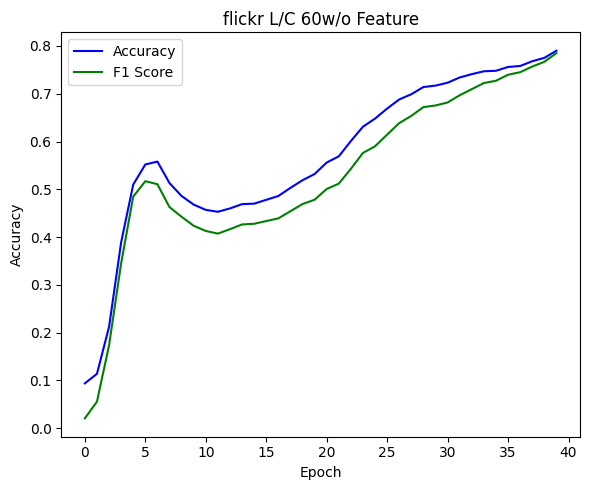

In [ ]:

# Plotting
plt.figure(figsize=(6, 5))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc_tests, label='Accuracy', color='blue')
plt.plot(range(epochs), macro_f1s, label='F1 Score', color='green')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(dataset + ' L/C ' + str(labelrate) + 'w/o Feature')
plt.legend()

# # Plot F1 score
# plt.subplot(1, 2, 2)
# plt.plot(range(epochs), macro_f1s, label='Macro F1 Score', color='green')
# plt.xlabel('Epoch')
# plt.ylabel('Macro F1 Score')
# plt.title('Macro F1 Score per Epoch')
# plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model = FGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:

acc_tests = []
macro_f1s = []

acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_f(model, epoch)
    acc_tests.append(acc_test)
    macro_f1s.append(macro_f1)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 2.2000 atr: 0.0963 ate: 0.2940 f1te:0.2240
e:1 ltr: 2.1759 atr: 0.3593 ate: 0.3810 f1te:0.3027
e:2 ltr: 2.1536 atr: 0.4889 ate: 0.4440 f1te:0.3728
e:3 ltr: 2.1318 atr: 0.5796 ate: 0.5000 f1te:0.4362
e:4 ltr: 2.1074 atr: 0.6630 ate: 0.5410 f1te:0.4828
e:5 ltr: 2.0845 atr: 0.6944 ate: 0.5550 f1te:0.5024
e:6 ltr: 2.0582 atr: 0.7333 ate: 0.5810 f1te:0.5329
e:7 ltr: 2.0317 atr: 0.7667 ate: 0.6110 f1te:0.5673
e:8 ltr: 2.0008 atr: 0.7944 ate: 0.6440 f1te:0.6033
e:9 ltr: 1.9699 atr: 0.8185 ate: 0.6580 f1te:0.6184
e:10 ltr: 1.9358 atr: 0.8500 ate: 0.6810 f1te:0.6441
e:11 ltr: 1.8995 atr: 0.8741 ate: 0.7010 f1te:0.6695
e:12 ltr: 1.8576 atr: 0.9037 ate: 0.7220 f1te:0.6931
e:13 ltr: 1.8177 atr: 0.9074 ate: 0.7450 f1te:0.7216
e:14 ltr: 1.7748 atr: 0.9241 ate: 0.7570 f1te:0.7373
e:15 ltr: 1.7264 atr: 0.9315 ate: 0.7750 f1te:0.7594
e:16 ltr: 1.6754 atr: 0.9426 ate: 0.7810 f1te:0.7670
e:17 ltr: 1.6204 atr: 0.9444 ate: 0.7880 f1te:0.7751
e:18 ltr: 1.5615 atr: 0.9463 ate: 0.7930 f1te:0.7824
e:1

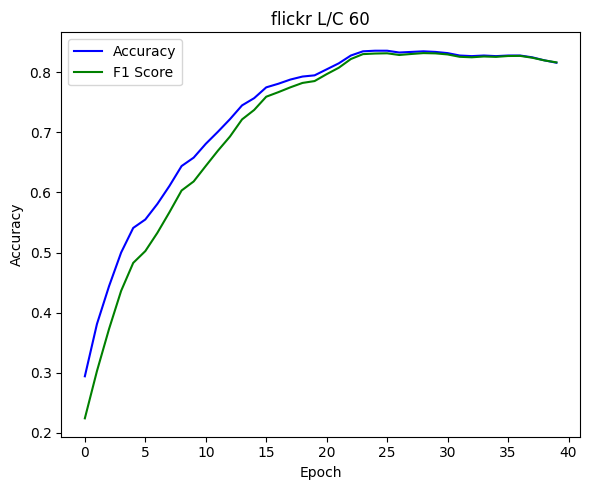

In [ ]:

# Plotting
plt.figure(figsize=(6, 5))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc_tests, label='Accuracy', color='blue')
plt.plot(range(epochs), macro_f1s, label='F1 Score', color='green')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(dataset + ' L/C ' + str(labelrate))
plt.legend()

# # Plot F1 score
# plt.subplot(1, 2, 2)
# plt.plot(range(epochs), macro_f1s, label='Macro F1 Score', color='green')
# plt.xlabel('Epoch')
# plt.ylabel('Macro F1 Score')
# plt.title('Macro F1 Score per Epoch')
# plt.legend()

plt.tight_layout()
plt.show()

# GAT

In [ ]:
class Attention(nn.Module):
    def __init__(self, in_size, hidden_size=16):
        super(Attention, self).__init__()

        self.project = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1, bias=False)
        )

    def forward(self, z):
        w = self.project(z)
        beta = torch.softmax(w, dim=1)
        return (beta * z).sum(1), beta


def train_gat(model, epochs):
    model.train()
    optimizer.zero_grad()
    output= model(features, sadj)
    loss_class =  F.nll_loss(output[idx_train], labels[idx_train])
    # loss_dep = (loss_dependence(emb1, com1, n) + loss_dependence(emb2, com2, n))/2
    # loss_com = common_loss(com1,com2)
    loss = loss_class
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    acc_test, macro_f1 = main_test_gcn(model)
    print('e:{}'.format(epochs),
            'ltr: {:.4f}'.format(loss.item()),
            'atr: {:.4f}'.format(acc.item()),
            'ate: {:.4f}'.format(acc_test.item()),
            'f1te:{:.4f}'.format(macro_f1.item()))
    return loss.item(), acc_test.item(), macro_f1.item()

def main_test_gcn(model):
    model.eval()
    output = model(features, sadj)
    acc_test = accuracy(output[idx_test], labels[idx_test])
    label_max = []
    for idx in idx_test:
        label_max.append(torch.argmax(output[idx]).item())
    labelcpu = labels[idx_test].data.cpu()
    macro_f1 = f1_score(labelcpu, label_max, average='macro')
    return acc_test, macro_f1

# Structural only

In [ ]:
model = SGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_s(model, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 1.7739 atr: 0.3250 ate: 0.3660 f1te:0.2302
e:1 ltr: 1.7561 atr: 0.4667 ate: 0.4650 f1te:0.3372
e:2 ltr: 1.7393 atr: 0.6167 ate: 0.5490 f1te:0.4502
e:3 ltr: 1.7222 atr: 0.7583 ate: 0.6160 f1te:0.5417
e:4 ltr: 1.7036 atr: 0.8583 ate: 0.6730 f1te:0.6168
e:5 ltr: 1.6851 atr: 0.9000 ate: 0.7080 f1te:0.6567
e:6 ltr: 1.6662 atr: 0.9167 ate: 0.7260 f1te:0.6764
e:7 ltr: 1.6466 atr: 0.9083 ate: 0.7310 f1te:0.6861
e:8 ltr: 1.6237 atr: 0.9167 ate: 0.7300 f1te:0.6870
e:9 ltr: 1.5971 atr: 0.9250 ate: 0.7350 f1te:0.6933
e:10 ltr: 1.5761 atr: 0.9083 ate: 0.7310 f1te:0.6899
e:11 ltr: 1.5460 atr: 0.9083 ate: 0.7290 f1te:0.6878
e:12 ltr: 1.5120 atr: 0.9167 ate: 0.7290 f1te:0.6891
e:13 ltr: 1.4767 atr: 0.9250 ate: 0.7290 f1te:0.6892
e:14 ltr: 1.4385 atr: 0.9167 ate: 0.7290 f1te:0.6897
e:15 ltr: 1.3998 atr: 0.9083 ate: 0.7270 f1te:0.6865
e:16 ltr: 1.3527 atr: 0.9167 ate: 0.7280 f1te:0.6876
e:17 ltr: 1.2996 atr: 0.9167 ate: 0.7280 f1te:0.6875
e:18 ltr: 1.2485 atr: 0.9083 ate: 0.7250 f1te:0.6851
e:1

# Feature only

In [ ]:
model = FGCN(nfeat = fdim,
            nhid1 = nhid1,
            nhid2 = nhid2,
            nclass = class_num,
            n = n,
            dropout = dropout)

In [ ]:

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
if cuda:
    model.cuda()
    features = features.cuda()
    sadj = sadj.cuda()
    fadj = fadj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



In [ ]:


acc_max = 0
f1_max = 0
epoch_max = 0
for epoch in range(epochs):
    loss, acc_test, macro_f1, emb = train_f(model, epoch)
    if acc_test >= acc_max:
        acc_max = acc_test
        f1_max = macro_f1
        epoch_max = epoch
print('epoch:{}'.format(epoch_max),
        'acc_max: {:.4f}'.format(acc_max),
        'f1_max: {:.4f}'.format(f1_max))


e:0 ltr: 1.7930 atr: 0.1000 ate: 0.2340 f1te:0.1609
e:1 ltr: 1.7794 atr: 0.3333 ate: 0.3080 f1te:0.2139
e:2 ltr: 1.7669 atr: 0.4833 ate: 0.3840 f1te:0.2984
e:3 ltr: 1.7542 atr: 0.5250 ate: 0.4820 f1te:0.4280
e:4 ltr: 1.7427 atr: 0.6750 ate: 0.5740 f1te:0.5410
e:5 ltr: 1.7300 atr: 0.7417 ate: 0.6270 f1te:0.5960
e:6 ltr: 1.7175 atr: 0.8000 ate: 0.6690 f1te:0.6361
e:7 ltr: 1.7032 atr: 0.8333 ate: 0.6780 f1te:0.6368
e:8 ltr: 1.6884 atr: 0.8083 ate: 0.6920 f1te:0.6457
e:9 ltr: 1.6746 atr: 0.8250 ate: 0.6990 f1te:0.6514
e:10 ltr: 1.6572 atr: 0.8083 ate: 0.7030 f1te:0.6551
e:11 ltr: 1.6400 atr: 0.8083 ate: 0.7120 f1te:0.6634
e:12 ltr: 1.6177 atr: 0.8167 ate: 0.7150 f1te:0.6644
e:13 ltr: 1.5953 atr: 0.8250 ate: 0.7150 f1te:0.6646
e:14 ltr: 1.5726 atr: 0.8250 ate: 0.7170 f1te:0.6647
e:15 ltr: 1.5456 atr: 0.8250 ate: 0.7170 f1te:0.6649
e:16 ltr: 1.5144 atr: 0.8250 ate: 0.7170 f1te:0.6649
e:17 ltr: 1.4805 atr: 0.8083 ate: 0.7190 f1te:0.6667
e:18 ltr: 1.4467 atr: 0.8250 ate: 0.7200 f1te:0.6655
e:1